In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
import pandas as pd

In [3]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [4]:
data = np.load("/kaggle/input/datasetcleaned/mars_for_students.npz")

In [5]:
X = np.load('/kaggle/input/datasetcleaned/X.npy')
y = np.load('/kaggle/input/datasetcleaned/y.npy')
X_test = data["test_set"]

In [6]:
import albumentations as A
aug = A.Compose(
    [
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=0.8)
    ]
)

In [7]:
for i in range(len(X)):
    if np.any(y[i] == 4):
        temp = aug(image = X[i], mask = y[i])
        temp_image = np.expand_dims(temp['image'], axis=0)  # Add a batch dimension
        temp_mask = np.expand_dims(temp['mask'], axis=0)    # Add a batch dimension

        
        X = np.concatenate((X, temp_image), axis=0)
        y = np.concatenate((y, temp_mask), axis=0)
        print(X.shape)



(2506, 64, 128)
(2507, 64, 128)
(2508, 64, 128)
(2509, 64, 128)
(2510, 64, 128)
(2511, 64, 128)
(2512, 64, 128)
(2513, 64, 128)
(2514, 64, 128)
(2515, 64, 128)
(2516, 64, 128)
(2517, 64, 128)
(2518, 64, 128)
(2519, 64, 128)
(2520, 64, 128)
(2521, 64, 128)
(2522, 64, 128)
(2523, 64, 128)
(2524, 64, 128)
(2525, 64, 128)
(2526, 64, 128)
(2527, 64, 128)
(2528, 64, 128)
(2529, 64, 128)
(2530, 64, 128)
(2531, 64, 128)
(2532, 64, 128)
(2533, 64, 128)
(2534, 64, 128)
(2535, 64, 128)
(2536, 64, 128)
(2537, 64, 128)
(2538, 64, 128)
(2539, 64, 128)
(2540, 64, 128)
(2541, 64, 128)
(2542, 64, 128)
(2543, 64, 128)
(2544, 64, 128)
(2545, 64, 128)
(2546, 64, 128)
(2547, 64, 128)
(2548, 64, 128)
(2549, 64, 128)
(2550, 64, 128)
(2551, 64, 128)
(2552, 64, 128)
(2553, 64, 128)
(2554, 64, 128)
(2555, 64, 128)
(2556, 64, 128)
(2557, 64, 128)
(2558, 64, 128)
(2559, 64, 128)
(2560, 64, 128)
(2561, 64, 128)
(2562, 64, 128)
(2563, 64, 128)
(2564, 64, 128)
(2565, 64, 128)
(2566, 64, 128)
(2567, 64, 128)
(2568, 6

In [8]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val,y_train, y_val = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train = (X_train[..., np.newaxis]) / 255.0
X_val = (X_val[..., np.newaxis]) / 255.0
X_test = (X_test[..., np.newaxis])/ 255.0
print("Data splitted!")
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)
print(X_test.shape)

Splitting data...
Data splitted!
X_train: (2054, 64, 128, 1) y_train: (2054, 64, 128) X_val: (514, 64, 128, 1) y_val: (514, 64, 128)
(10022, 64, 128, 1)


In [9]:
print(X_test.shape)

(10022, 64, 128, 1)


In [10]:
#Compute and adjust class weights
cw =compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train.flatten())
print(cw)
cw[0] = 0.0
print(cw)

[ 0.80921074  0.60725697  0.85744741  1.0654779  78.86189394]
[ 0.          0.60725697  0.85744741  1.0654779  78.86189394]


In [11]:
 category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4}  # Big Rock
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [12]:
def load_single_image(image, label, input_size=(64, 128)):
    
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [13]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [14]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [15]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'int32'>


In [17]:
def gate(e,d,filters):
    a = tfkl.Add()([e, d])
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(a)
    x = tfkl.Activation(activation="sigmoid")(x)
    b = tfkl.Multiply()([x, e])
    out = tfkl.Add()([a, b])
    return x

In [18]:
def se_block(input_tensor, name="SE"):
    filters = input_tensor.shape[-1]

    # Global Average Pooling
    se = tfkl.GlobalAveragePooling2D(name=f"{name}_global_avg_pool")(input_tensor)
    se = tfkl.Reshape((1, 1, filters), name=f"{name}_reshape")(se)

    # Depthwise Separable Scaling
    scale = tfkl.Conv2D(filters, kernel_size=1, activation='sigmoid', name=f"{name}_scale")(se)

    # Multiply input by scale
    output = tfkl.Multiply(name=f"{name}_scaled")([input_tensor, scale])
    return output


def unet_block(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor
    residual_tot = input_tensor  # Store the input as residual

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        residual = x  # Store the input as residual
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = tfkl.GroupNormalization(groups=16)(x)
        x = tfkl.Activation(activation)(x)

        # Match the dimensions of residual to x if they differ
        if residual.shape[-1] != filters:
            residual = tfkl.Conv2D(filters, kernel_size=1, padding='same')(residual)
    
        # Add residual connection
        x = tfkl.Add()([x, residual])
    if residual_tot.shape[-1] != filters:
            residual_tot = tfkl.Conv2D(filters, kernel_size=1, padding='same')(residual_tot)
    x = tfkl.Add()([x, residual_tot])
    # Return the transformed tensor
    return x


def get_unet_model_with_attention(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck with attention
    bottleneck = unet_block(d2, 128)
    bottleneck = se_block(bottleneck, name="bottleneck_attention")  # Apply attention here

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    x = unet_block(down_block_2, 128)
    u1 = gate(u1, x, 128)
    u1 = unet_block(u1, 64)

    u2 = tfkl.UpSampling2D()(u1)
    y = unet_block(down_block_1, 64)
    u2 = gate(u2, y, 64)
    u2 = unet_block(u2, 32)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_Attention')
    return model


In [19]:

model = get_unet_model_with_attention(input_shape=input_shape, num_classes=NUM_CLASSES)
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet_with_Attention"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d[0][0]   │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 64, 128, │         0 │ activation[0]… │   -   │
│                   │ 32)             │           │ conv2d_1[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ add[0][0]      │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d_2[0][0] │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_1 (Add)       │ (None, 64, 128, │         0 │ activation_1[… │   -   │
│                   │ 32)             │           │ add[0][0]      │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_2 (Add)       │ (None, 64, 128, │         0 │ add_1[0][0],   │   -   │
│                   │ 32)             │           │ conv2d_3[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ add_2[0][0]    │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 32, 64,  │       128 │ conv2d_4[0][0] │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ group_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_5 (Conv2D) │ (None, 32, 64,  │     2,112 │ max_pooling2d… │   Y 

 Total params: 803,653 (3.07 MB)

 Trainable params: 803,653 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def create_segmentation_colormap(num_classes):
    
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [21]:
import tensorflow.keras.backend as K

def focal_lossw(alpha=0.25, gamma=2.0, class_weights=None):
    def loss(y_true, y_pred):
        # Ensure y_true is one-hot encoded if not already
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute the focal loss scaling factor
        scaling_factor = tf.pow(1 - y_pred, gamma)

        # Apply the focal loss formula
        focal_loss = alpha * scaling_factor * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights to tensor
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            # Multiply the loss for each class by its weight
            focal_loss *= tf.expand_dims(tf.reduce_sum(y_true * class_weights_tensor, axis=-1), axis=-1)

        # Reduce the loss across spatial and class dimensions
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

focal = focal_lossw(alpha=0.25, gamma=2.0,class_weights=cw)
# Compile the model
print("Compiling model...")
model.compile(
    loss=focal,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,    # Adjust based on your dataset and model
    weight_decay=1e-3      # High decay to regularize small batches
),
    metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

#Implement Learning Rate Reducing
lr_callback = ReduceLROnPlateau(
    monitor='val_mean_iou',  # Metric to monitor
    mode = 'max',
    factor=0.5,          # Reduce LR by 50%
    patience=10,          # Wait 10 epochs of no improvement
    verbose=1,           # Print updates
    min_lr=1e-6          # Lower bound on LR
)

Epoch 1/1000


I0000 00:00:1734189066.936697      91 service.cc:145] XLA service 0x7a2460011f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734189066.936768      91 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734189066.936775      91 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/129 ━━━━━━━━━━━━━━━━━━━━ 1:09:39 33s/step - loss: 0.3340 - mean_iou: 0.0750

I0000 00:00:1734189086.786511      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1872 - mean_iou: 0.1145

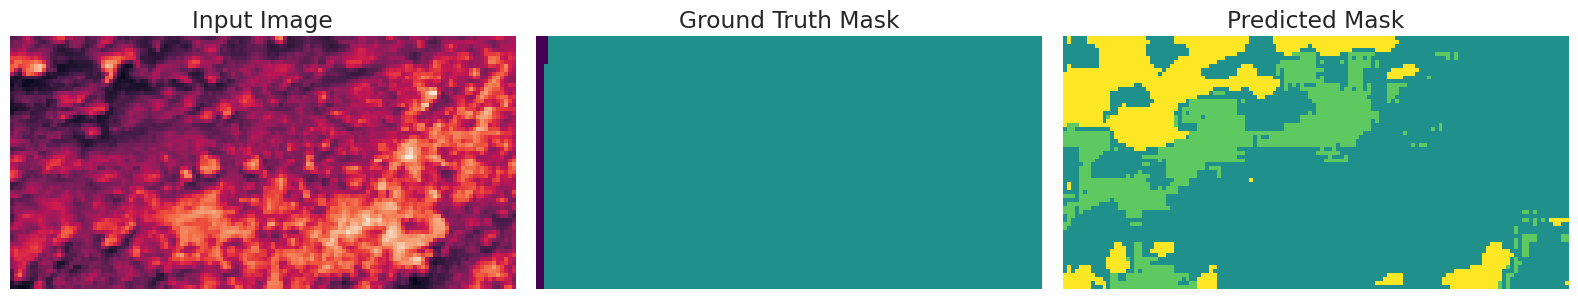

129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - loss: 0.1870 - mean_iou: 0.1147 - val_loss: 0.1152 - val_mean_iou: 0.2079 - learning_rate: 0.0010
Epoch 2/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.1122 - mean_iou: 0.2385 - val_loss: 0.0915 - val_mean_iou: 0.2476 - learning_rate: 0.0010
Epoch 3/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0880 - mean_iou: 0.3311 - val_loss: 0.0853 - val_mean_iou: 0.2916 - learning_rate: 0.0010
Epoch 4/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0801 - mean_iou: 0.3456 - val_loss: 0.0644 - val_mean_iou: 0.4076 - learning_rate: 0.0010
Epoch 5/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0727 - mean_iou: 0.3827 - val_loss: 0.0650 - val_mean_iou: 0.3891 - learning_rate: 0.0010
Epoch 6/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0668 - mean_iou: 0.4064

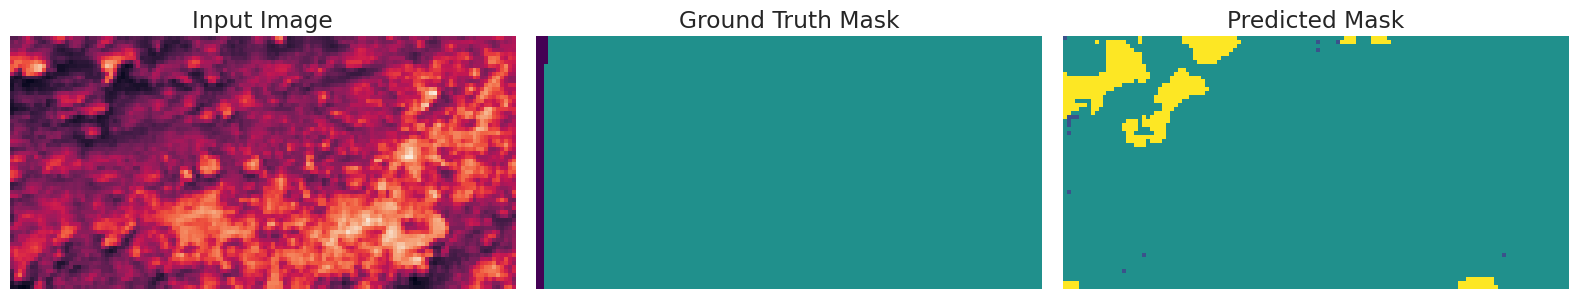

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0668 - mean_iou: 0.4066 - val_loss: 0.0644 - val_mean_iou: 0.3674 - learning_rate: 0.0010
Epoch 7/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0723 - mean_iou: 0.3928 - val_loss: 0.0583 - val_mean_iou: 0.4418 - learning_rate: 0.0010
Epoch 8/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0607 - mean_iou: 0.4200 - val_loss: 0.0556 - val_mean_iou: 0.4264 - learning_rate: 0.0010
Epoch 9/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0586 - mean_iou: 0.4307 - val_loss: 0.0571 - val_mean_iou: 0.4456 - learning_rate: 0.0010
Epoch 10/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0594 - mean_iou: 0.4468 - val_loss: 0.0539 - val_mean_iou: 0.4557 - learning_rate: 0.0010
Epoch 11/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0557 - mean_iou: 0.4653

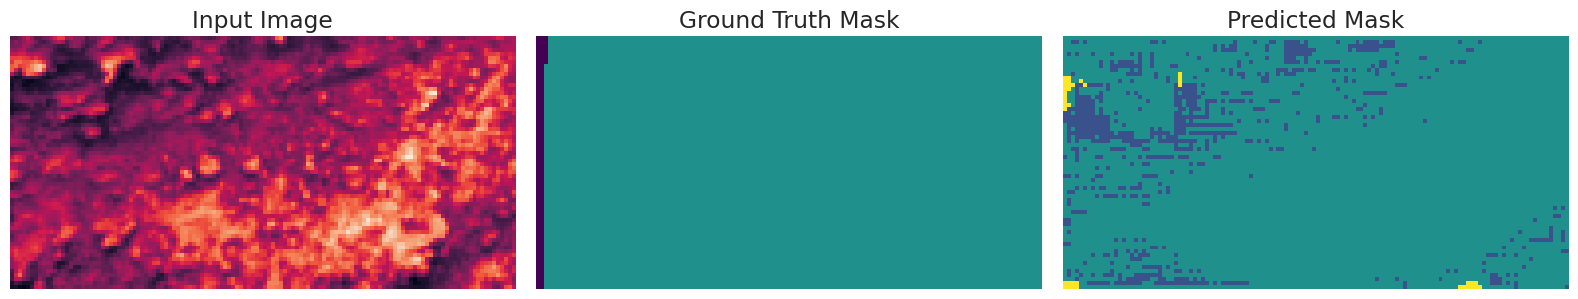

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0557 - mean_iou: 0.4651 - val_loss: 0.0525 - val_mean_iou: 0.4698 - learning_rate: 0.0010
Epoch 12/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0563 - mean_iou: 0.4565 - val_loss: 0.0534 - val_mean_iou: 0.4381 - learning_rate: 0.0010
Epoch 13/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0541 - mean_iou: 0.4538 - val_loss: 0.0565 - val_mean_iou: 0.4196 - learning_rate: 0.0010
Epoch 14/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0544 - mean_iou: 0.4376 - val_loss: 0.0508 - val_mean_iou: 0.4756 - learning_rate: 0.0010
Epoch 15/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0515 - mean_iou: 0.4803 - val_loss: 0.0541 - val_mean_iou: 0.4434 - learning_rate: 0.0010
Epoch 16/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0500 - mean_iou: 0.4785

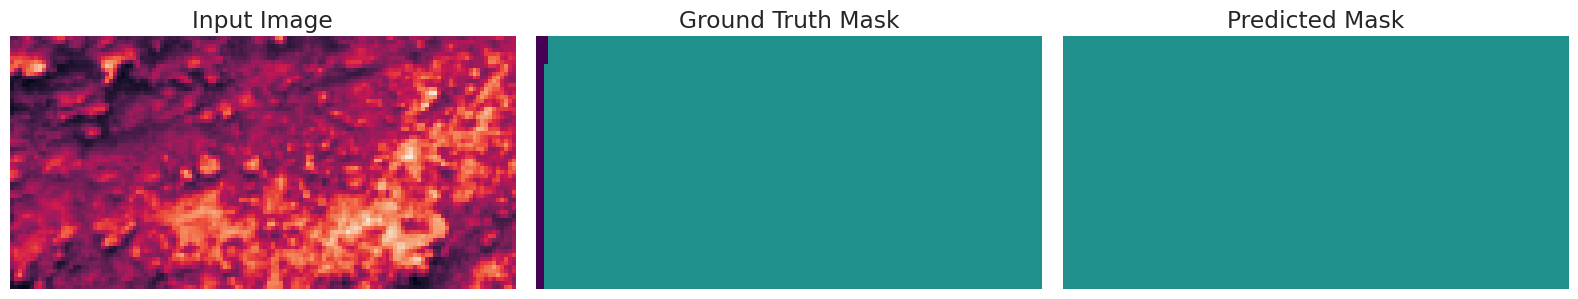

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0499 - mean_iou: 0.4785 - val_loss: 0.0510 - val_mean_iou: 0.4764 - learning_rate: 0.0010
Epoch 17/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0500 - mean_iou: 0.4861 - val_loss: 0.0460 - val_mean_iou: 0.5053 - learning_rate: 0.0010
Epoch 18/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0561 - mean_iou: 0.4827 - val_loss: 0.0510 - val_mean_iou: 0.4608 - learning_rate: 0.0010
Epoch 19/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0468 - mean_iou: 0.4949 - val_loss: 0.0469 - val_mean_iou: 0.5136 - learning_rate: 0.0010
Epoch 20/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0416 - mean_iou: 0.5213 - val_loss: 0.0443 - val_mean_iou: 0.5245 - learning_rate: 0.0010
Epoch 21/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0420 - mean_iou: 0.5235

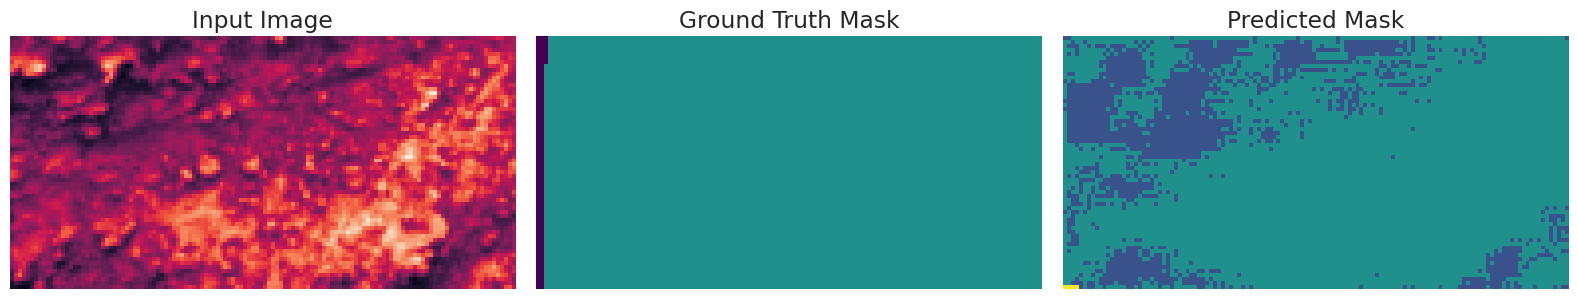

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0420 - mean_iou: 0.5234 - val_loss: 0.0460 - val_mean_iou: 0.5155 - learning_rate: 0.0010
Epoch 22/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0409 - mean_iou: 0.5251 - val_loss: 0.0455 - val_mean_iou: 0.4936 - learning_rate: 0.0010
Epoch 23/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0975 - mean_iou: 0.3926 - val_loss: 0.0518 - val_mean_iou: 0.4933 - learning_rate: 0.0010
Epoch 24/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0473 - mean_iou: 0.5024 - val_loss: 0.0447 - val_mean_iou: 0.4954 - learning_rate: 0.0010
Epoch 25/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0417 - mean_iou: 0.5180 - val_loss: 0.0491 - val_mean_iou: 0.4583 - learning_rate: 0.0010
Epoch 26/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0421 - mean_iou: 0.5214

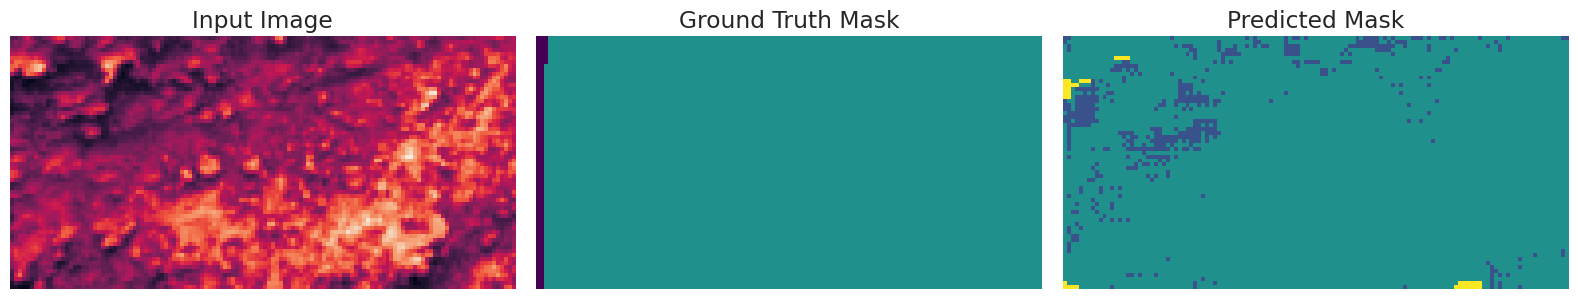

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0421 - mean_iou: 0.5215 - val_loss: 0.0468 - val_mean_iou: 0.5037 - learning_rate: 0.0010
Epoch 27/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0375 - mean_iou: 0.5307 - val_loss: 0.0494 - val_mean_iou: 0.5180 - learning_rate: 0.0010
Epoch 28/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0363 - mean_iou: 0.5517 - val_loss: 0.0495 - val_mean_iou: 0.5221 - learning_rate: 0.0010
Epoch 29/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0334 - mean_iou: 0.5571 - val_loss: 0.0402 - val_mean_iou: 0.5415 - learning_rate: 0.0010
Epoch 30/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0331 - mean_iou: 0.5547 - val_loss: 0.0549 - val_mean_iou: 0.5143 - learning_rate: 0.0010
Epoch 31/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0360 - mean_iou: 0.5367

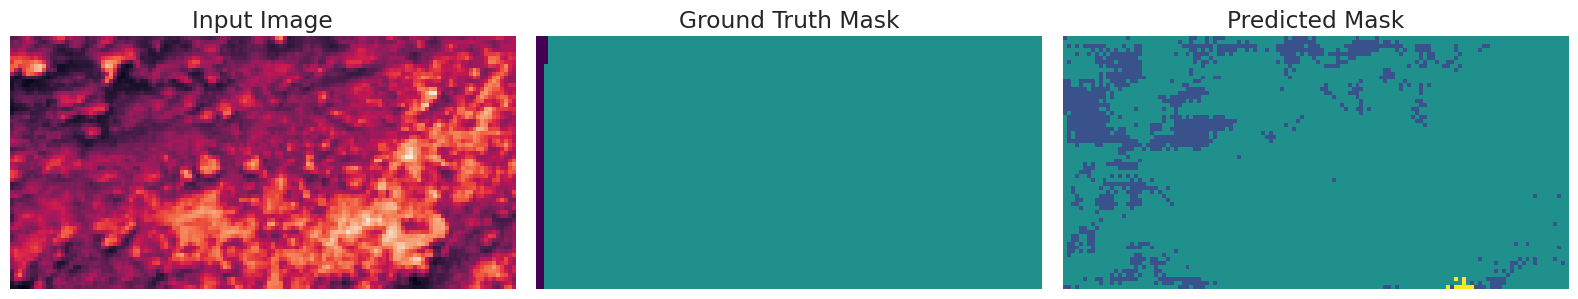

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0360 - mean_iou: 0.5368 - val_loss: 0.0395 - val_mean_iou: 0.5554 - learning_rate: 0.0010
Epoch 32/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0324 - mean_iou: 0.5569 - val_loss: 0.0442 - val_mean_iou: 0.5559 - learning_rate: 0.0010
Epoch 33/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0348 - mean_iou: 0.5588 - val_loss: 0.0430 - val_mean_iou: 0.5435 - learning_rate: 0.0010
Epoch 34/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0396 - mean_iou: 0.5404 - val_loss: 0.0558 - val_mean_iou: 0.4951 - learning_rate: 0.0010
Epoch 35/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0363 - mean_iou: 0.5405 - val_loss: 0.0560 - val_mean_iou: 0.4698 - learning_rate: 0.0010
Epoch 36/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0358 - mean_iou: 0.5472

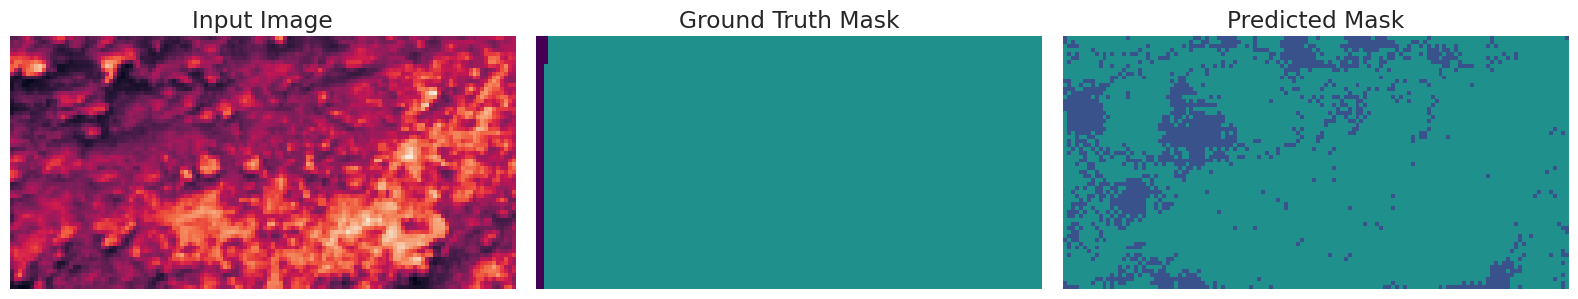

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0358 - mean_iou: 0.5474 - val_loss: 0.0412 - val_mean_iou: 0.5434 - learning_rate: 0.0010
Epoch 37/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0322 - mean_iou: 0.5604 - val_loss: 0.0382 - val_mean_iou: 0.5594 - learning_rate: 0.0010
Epoch 38/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0273 - mean_iou: 0.5842 - val_loss: 0.0351 - val_mean_iou: 0.5637 - learning_rate: 0.0010
Epoch 39/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0275 - mean_iou: 0.5827 - val_loss: 0.0440 - val_mean_iou: 0.5711 - learning_rate: 0.0010
Epoch 40/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0329 - mean_iou: 0.5579 - val_loss: 0.0399 - val_mean_iou: 0.5891 - learning_rate: 0.0010
Epoch 41/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0263 - mean_iou: 0.6002

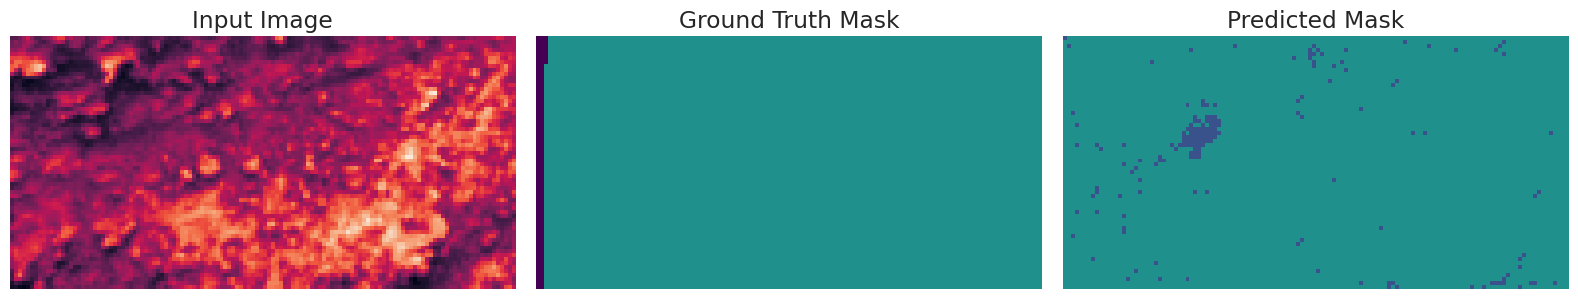

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0263 - mean_iou: 0.5999 - val_loss: 0.0492 - val_mean_iou: 0.5408 - learning_rate: 0.0010
Epoch 42/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0322 - mean_iou: 0.5626 - val_loss: 0.0368 - val_mean_iou: 0.5749 - learning_rate: 0.0010
Epoch 43/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0292 - mean_iou: 0.5713 - val_loss: 0.0430 - val_mean_iou: 0.5342 - learning_rate: 0.0010
Epoch 44/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0258 - mean_iou: 0.5803 - val_loss: 0.0510 - val_mean_iou: 0.4987 - learning_rate: 0.0010
Epoch 45/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0250 - mean_iou: 0.5932 - val_loss: 0.0553 - val_mean_iou: 0.4499 - learning_rate: 0.0010
Epoch 46/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0267 - mean_iou: 0.5623

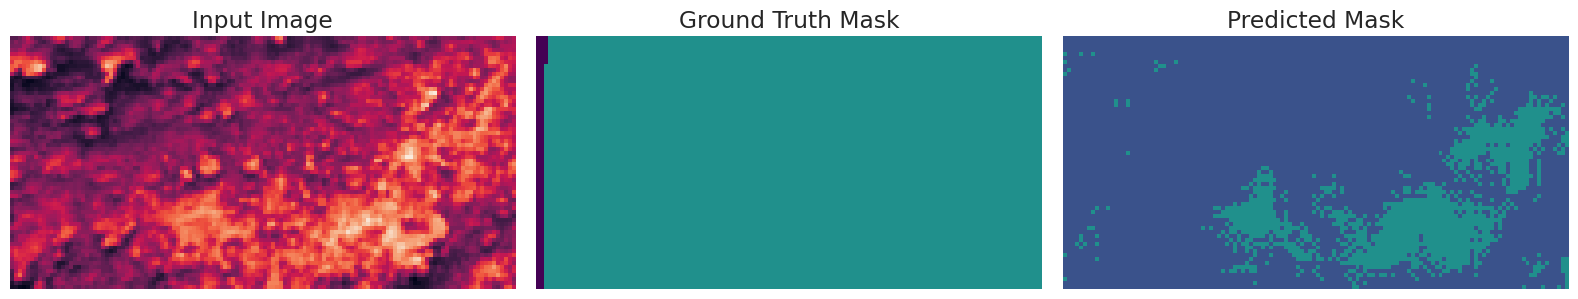

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0266 - mean_iou: 0.5627 - val_loss: 0.0498 - val_mean_iou: 0.5577 - learning_rate: 0.0010
Epoch 47/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0225 - mean_iou: 0.6089 - val_loss: 0.0354 - val_mean_iou: 0.5848 - learning_rate: 0.0010
Epoch 48/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0207 - mean_iou: 0.6231 - val_loss: 0.0383 - val_mean_iou: 0.5620 - learning_rate: 0.0010
Epoch 49/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0336 - mean_iou: 0.5611 - val_loss: 0.0538 - val_mean_iou: 0.4719 - learning_rate: 0.0010
Epoch 50/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0411 - mean_iou: 0.5326
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0410 - mean_iou: 0.5329 - val_loss: 0.0390 - val_mean_iou: 0.5408 - learning_rate: 0.0010
Epoch 51/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0261 - mea

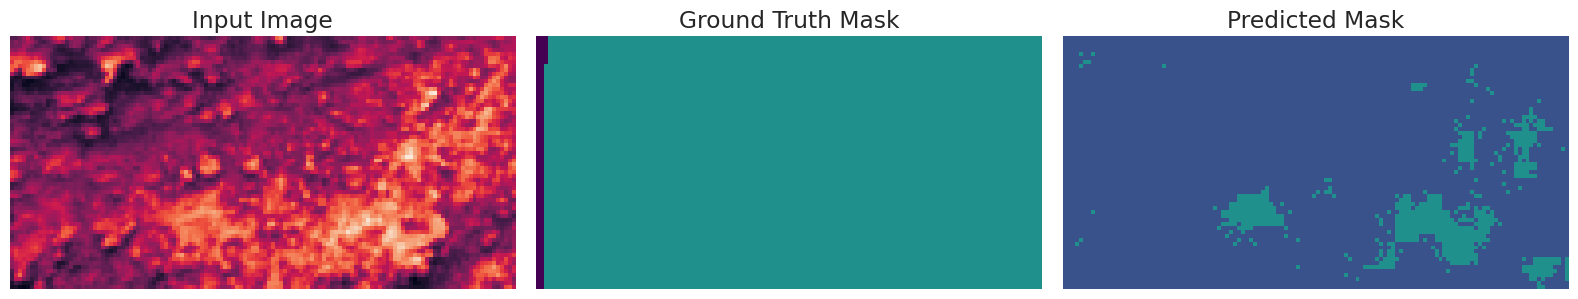

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0260 - mean_iou: 0.5890 - val_loss: 0.0311 - val_mean_iou: 0.5895 - learning_rate: 5.0000e-04
Epoch 52/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0205 - mean_iou: 0.6320 - val_loss: 0.0296 - val_mean_iou: 0.5945 - learning_rate: 5.0000e-04
Epoch 53/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0185 - mean_iou: 0.6370 - val_loss: 0.0305 - val_mean_iou: 0.6025 - learning_rate: 5.0000e-04
Epoch 54/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0173 - mean_iou: 0.6511 - val_loss: 0.0316 - val_mean_iou: 0.6150 - learning_rate: 5.0000e-04
Epoch 55/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0170 - mean_iou: 0.6529 - val_loss: 0.0330 - val_mean_iou: 0.6125 - learning_rate: 5.0000e-04
Epoch 56/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0162 - mean_iou: 0.6583

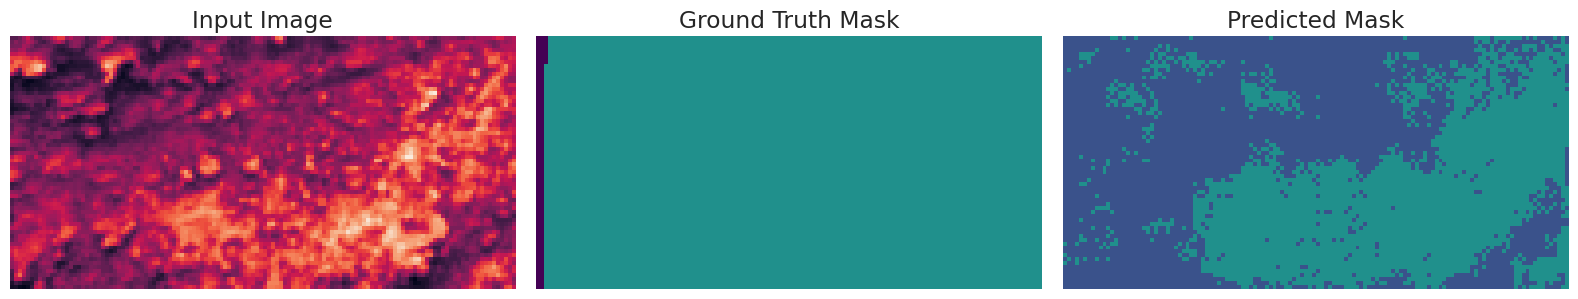

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0162 - mean_iou: 0.6582 - val_loss: 0.0300 - val_mean_iou: 0.6080 - learning_rate: 5.0000e-04
Epoch 57/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0159 - mean_iou: 0.6587 - val_loss: 0.0330 - val_mean_iou: 0.6246 - learning_rate: 5.0000e-04
Epoch 58/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0143 - mean_iou: 0.6799 - val_loss: 0.0339 - val_mean_iou: 0.6186 - learning_rate: 5.0000e-04
Epoch 59/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0154 - mean_iou: 0.6706 - val_loss: 0.0381 - val_mean_iou: 0.5943 - learning_rate: 5.0000e-04
Epoch 60/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0183 - mean_iou: 0.6356 - val_loss: 0.0393 - val_mean_iou: 0.6296 - learning_rate: 5.0000e-04
Epoch 61/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0141 - mean_iou: 0.6830

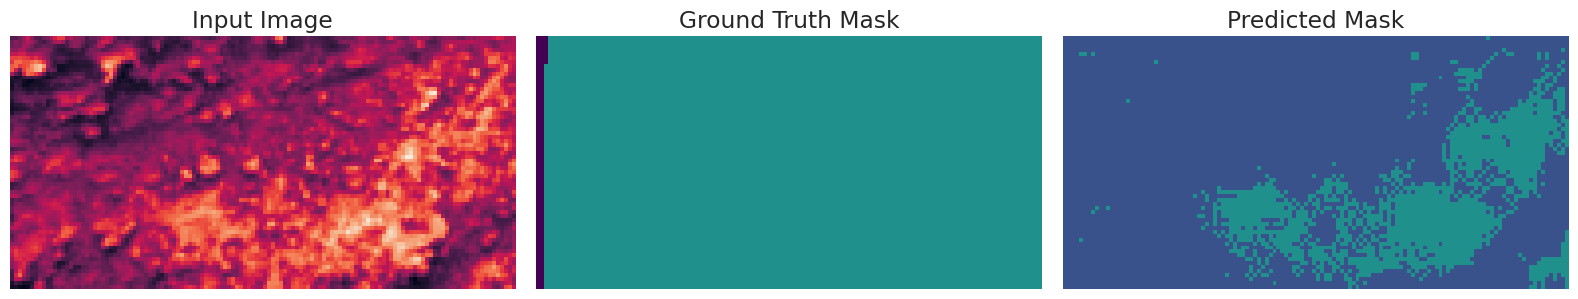

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0141 - mean_iou: 0.6829 - val_loss: 0.0319 - val_mean_iou: 0.6340 - learning_rate: 5.0000e-04
Epoch 62/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0137 - mean_iou: 0.6871 - val_loss: 0.0380 - val_mean_iou: 0.6353 - learning_rate: 5.0000e-04
Epoch 63/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0131 - mean_iou: 0.6961 - val_loss: 0.0406 - val_mean_iou: 0.6329 - learning_rate: 5.0000e-04
Epoch 64/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0136 - mean_iou: 0.6980 - val_loss: 0.0329 - val_mean_iou: 0.6321 - learning_rate: 5.0000e-04
Epoch 65/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0135 - mean_iou: 0.6856 - val_loss: 0.0368 - val_mean_iou: 0.6408 - learning_rate: 5.0000e-04
Epoch 66/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0120 - mean_iou: 0.7178

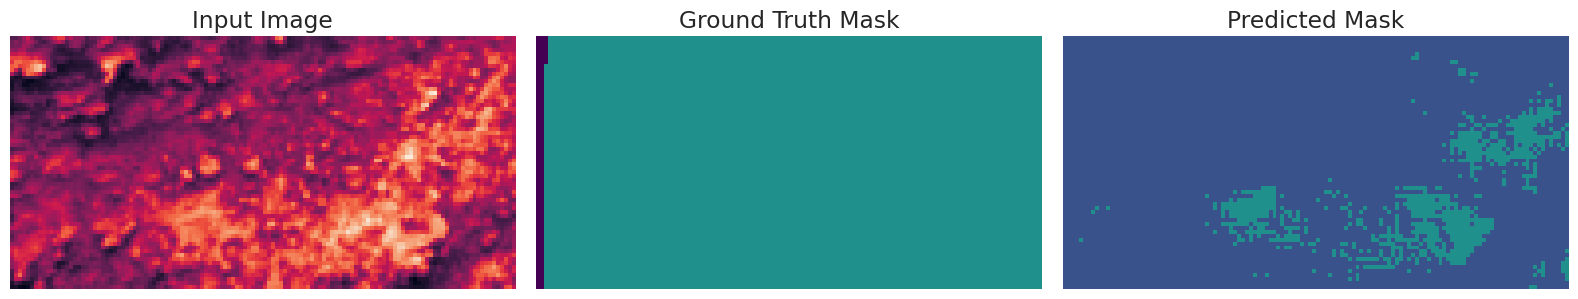

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0120 - mean_iou: 0.7176 - val_loss: 0.0346 - val_mean_iou: 0.6385 - learning_rate: 5.0000e-04
Epoch 67/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0124 - mean_iou: 0.7066 - val_loss: 0.0436 - val_mean_iou: 0.5907 - learning_rate: 5.0000e-04
Epoch 68/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0174 - mean_iou: 0.6519 - val_loss: 0.0333 - val_mean_iou: 0.6339 - learning_rate: 5.0000e-04
Epoch 69/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0130 - mean_iou: 0.6927 - val_loss: 0.0354 - val_mean_iou: 0.6383 - learning_rate: 5.0000e-04
Epoch 70/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0113 - mean_iou: 0.7236 - val_loss: 0.0356 - val_mean_iou: 0.6387 - learning_rate: 5.0000e-04
Epoch 71/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0107 - mean_iou: 0.7330

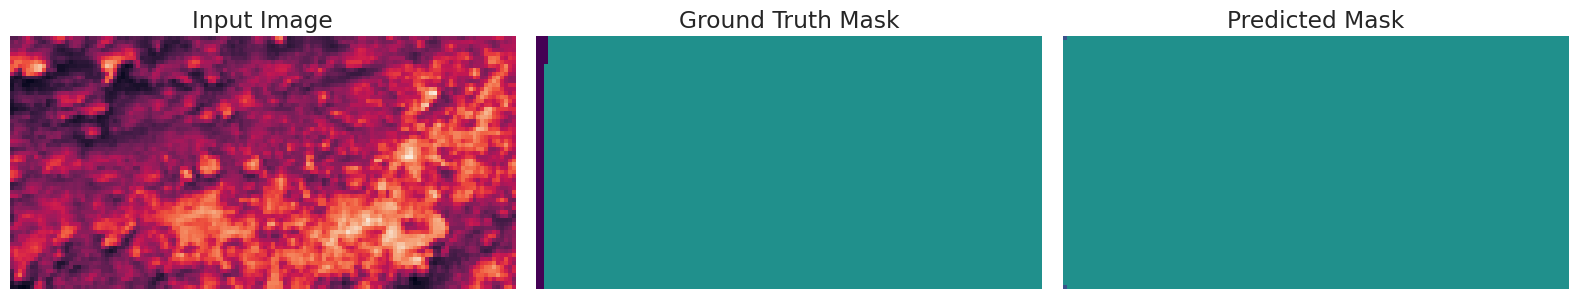

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0107 - mean_iou: 0.7329 - val_loss: 0.0382 - val_mean_iou: 0.6172 - learning_rate: 5.0000e-04
Epoch 72/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0117 - mean_iou: 0.7131 - val_loss: 0.0391 - val_mean_iou: 0.6327 - learning_rate: 5.0000e-04
Epoch 73/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0105 - mean_iou: 0.7350 - val_loss: 0.0394 - val_mean_iou: 0.6409 - learning_rate: 5.0000e-04
Epoch 74/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0101 - mean_iou: 0.7427 - val_loss: 0.0308 - val_mean_iou: 0.6224 - learning_rate: 5.0000e-04
Epoch 75/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0155 - mean_iou: 0.6631 - val_loss: 0.0423 - val_mean_iou: 0.6224 - learning_rate: 5.0000e-04
Epoch 76/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0182 - mean_iou: 0.6628

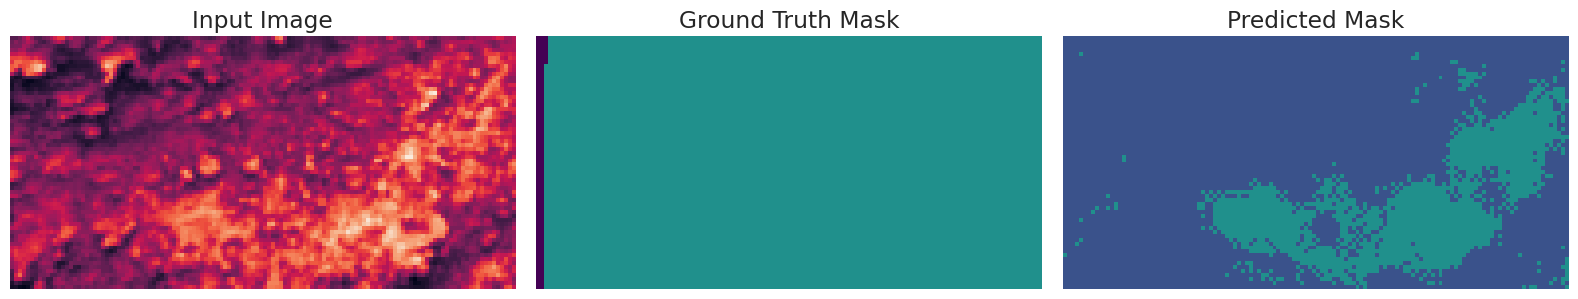

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0182 - mean_iou: 0.6628 - val_loss: 0.0452 - val_mean_iou: 0.6342 - learning_rate: 5.0000e-04
Epoch 77/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0110 - mean_iou: 0.7332 - val_loss: 0.0310 - val_mean_iou: 0.6295 - learning_rate: 5.0000e-04
Epoch 78/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0106 - mean_iou: 0.7233 - val_loss: 0.0418 - val_mean_iou: 0.6217 - learning_rate: 5.0000e-04
Epoch 79/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0112 - mean_iou: 0.7128 - val_loss: 0.0415 - val_mean_iou: 0.6400 - learning_rate: 5.0000e-04
Epoch 80/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0102 - mean_iou: 0.7410 - val_loss: 0.0463 - val_mean_iou: 0.6377 - learning_rate: 5.0000e-04
Epoch 81/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0092 - mean_iou: 0.7588

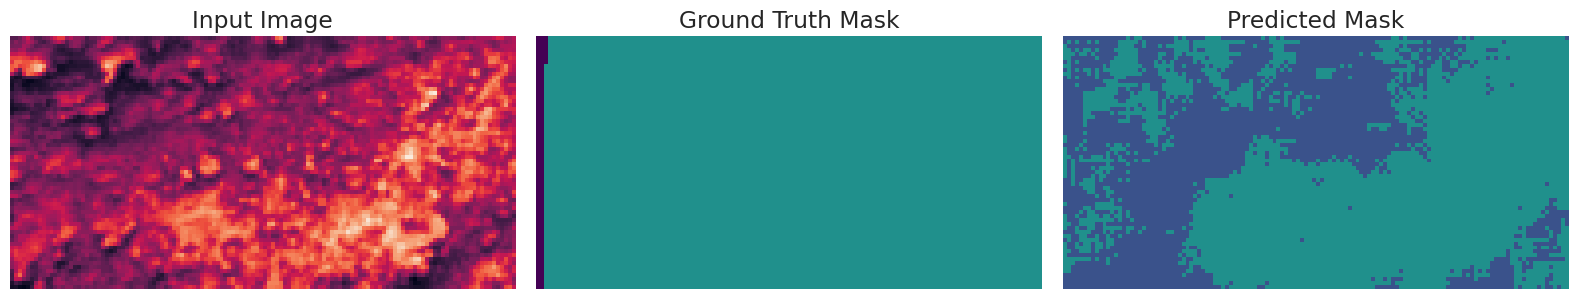

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0092 - mean_iou: 0.7588 - val_loss: 0.0431 - val_mean_iou: 0.6552 - learning_rate: 5.0000e-04
Epoch 82/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0086 - mean_iou: 0.7749 - val_loss: 0.0453 - val_mean_iou: 0.6420 - learning_rate: 5.0000e-04
Epoch 83/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0086 - mean_iou: 0.7580 - val_loss: 0.0501 - val_mean_iou: 0.6450 - learning_rate: 5.0000e-04
Epoch 84/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0086 - mean_iou: 0.7748 - val_loss: 0.0441 - val_mean_iou: 0.6584 - learning_rate: 5.0000e-04
Epoch 85/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0084 - mean_iou: 0.7628 - val_loss: 0.0565 - val_mean_iou: 0.6414 - learning_rate: 5.0000e-04
Epoch 86/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0137 - mean_iou: 0.6962

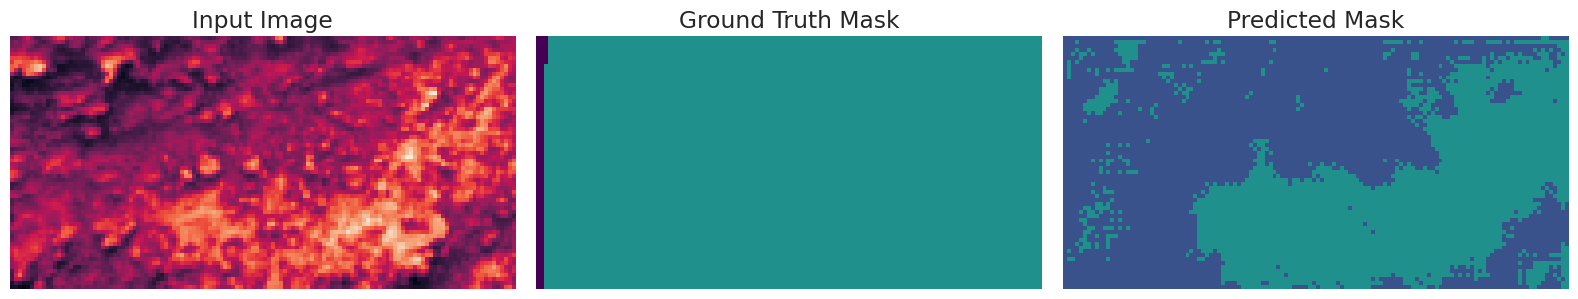

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0137 - mean_iou: 0.6959 - val_loss: 0.0400 - val_mean_iou: 0.6411 - learning_rate: 5.0000e-04
Epoch 87/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0104 - mean_iou: 0.7283 - val_loss: 0.0444 - val_mean_iou: 0.6330 - learning_rate: 5.0000e-04
Epoch 88/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0283 - mean_iou: 0.5141 - val_loss: 0.0337 - val_mean_iou: 0.6096 - learning_rate: 5.0000e-04
Epoch 89/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0169 - mean_iou: 0.6662 - val_loss: 0.0377 - val_mean_iou: 0.6360 - learning_rate: 5.0000e-04
Epoch 90/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0102 - mean_iou: 0.7263 - val_loss: 0.0371 - val_mean_iou: 0.6401 - learning_rate: 5.0000e-04
Epoch 91/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0089 - mean_iou: 0.7503

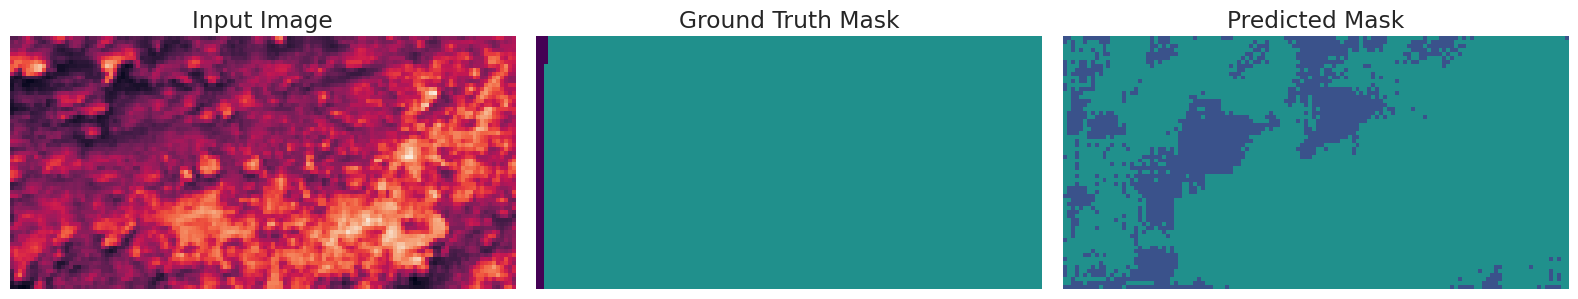

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0089 - mean_iou: 0.7503 - val_loss: 0.0365 - val_mean_iou: 0.6455 - learning_rate: 5.0000e-04
Epoch 92/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0090 - mean_iou: 0.7453 - val_loss: 0.0413 - val_mean_iou: 0.6634 - learning_rate: 5.0000e-04
Epoch 93/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0075 - mean_iou: 0.7871 - val_loss: 0.0438 - val_mean_iou: 0.6585 - learning_rate: 5.0000e-04
Epoch 94/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0071 - mean_iou: 0.7916 - val_loss: 0.0494 - val_mean_iou: 0.6581 - learning_rate: 5.0000e-04
Epoch 95/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0069 - mean_iou: 0.8007 - val_loss: 0.0507 - val_mean_iou: 0.6519 - learning_rate: 5.0000e-04
Epoch 96/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0083 - mean_iou: 0.7603

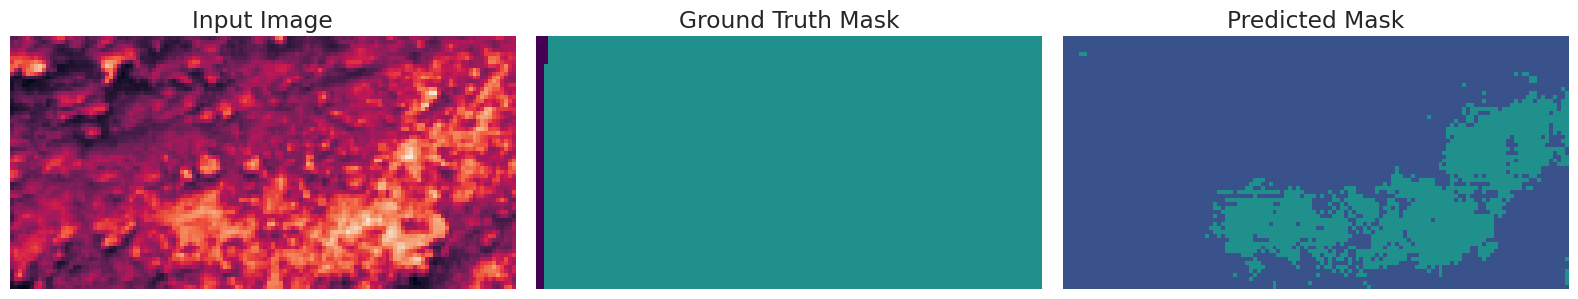

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0083 - mean_iou: 0.7601 - val_loss: 0.0509 - val_mean_iou: 0.6665 - learning_rate: 5.0000e-04
Epoch 97/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0070 - mean_iou: 0.8062 - val_loss: 0.0496 - val_mean_iou: 0.6537 - learning_rate: 5.0000e-04
Epoch 98/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0070 - mean_iou: 0.8030 - val_loss: 0.0404 - val_mean_iou: 0.6565 - learning_rate: 5.0000e-04
Epoch 99/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0070 - mean_iou: 0.7938 - val_loss: 0.0471 - val_mean_iou: 0.6646 - learning_rate: 5.0000e-04
Epoch 100/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0063 - mean_iou: 0.8196 - val_loss: 0.0529 - val_mean_iou: 0.6702 - learning_rate: 5.0000e-04
Epoch 101/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0062 - mean_iou: 0.8320

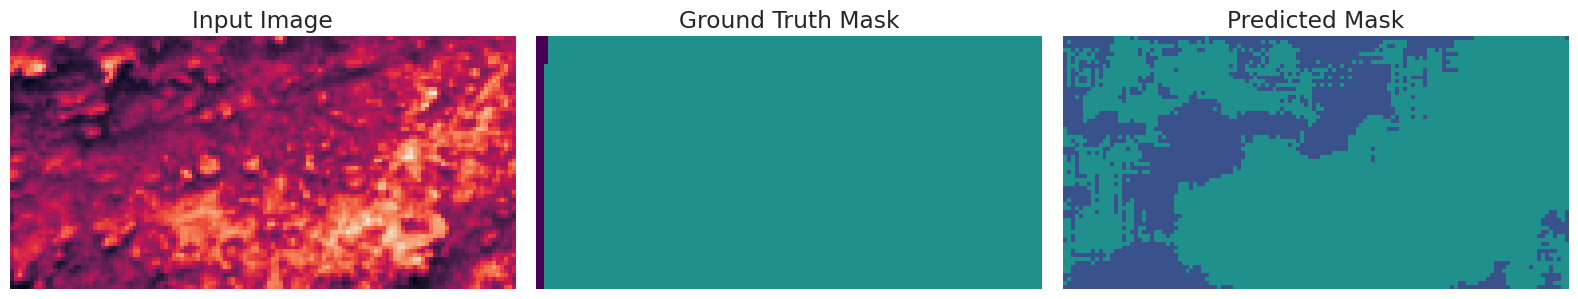

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0062 - mean_iou: 0.8318 - val_loss: 0.0511 - val_mean_iou: 0.6694 - learning_rate: 5.0000e-04
Epoch 102/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0058 - mean_iou: 0.8423 - val_loss: 0.0492 - val_mean_iou: 0.6682 - learning_rate: 5.0000e-04
Epoch 103/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0094 - mean_iou: 0.7589 - val_loss: 0.0432 - val_mean_iou: 0.6413 - learning_rate: 5.0000e-04
Epoch 104/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0102 - mean_iou: 0.7280 - val_loss: 0.0422 - val_mean_iou: 0.6537 - learning_rate: 5.0000e-04
Epoch 105/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0065 - mean_iou: 0.8017 - val_loss: 0.0483 - val_mean_iou: 0.6059 - learning_rate: 5.0000e-04
Epoch 106/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0099 - mean_iou: 0.7492

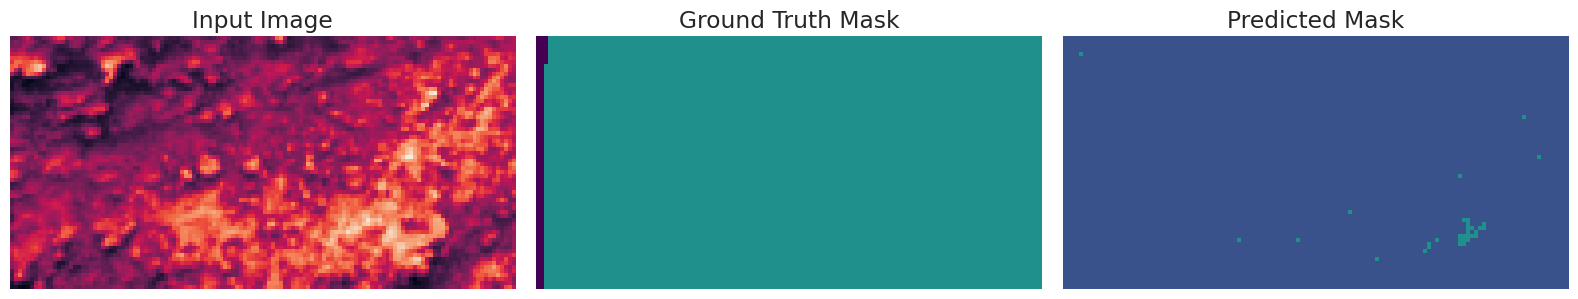

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0099 - mean_iou: 0.7494 - val_loss: 0.0443 - val_mean_iou: 0.6641 - learning_rate: 5.0000e-04
Epoch 107/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0062 - mean_iou: 0.8206 - val_loss: 0.0463 - val_mean_iou: 0.6602 - learning_rate: 5.0000e-04
Epoch 108/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0060 - mean_iou: 0.8183 - val_loss: 0.0527 - val_mean_iou: 0.6502 - learning_rate: 5.0000e-04
Epoch 109/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0067 - mean_iou: 0.8035 - val_loss: 0.0554 - val_mean_iou: 0.6700 - learning_rate: 5.0000e-04
Epoch 110/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0058 - mean_iou: 0.8191 - val_loss: 0.0553 - val_mean_iou: 0.6746 - learning_rate: 5.0000e-04
Epoch 111/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0057 - mean_iou: 0.8192

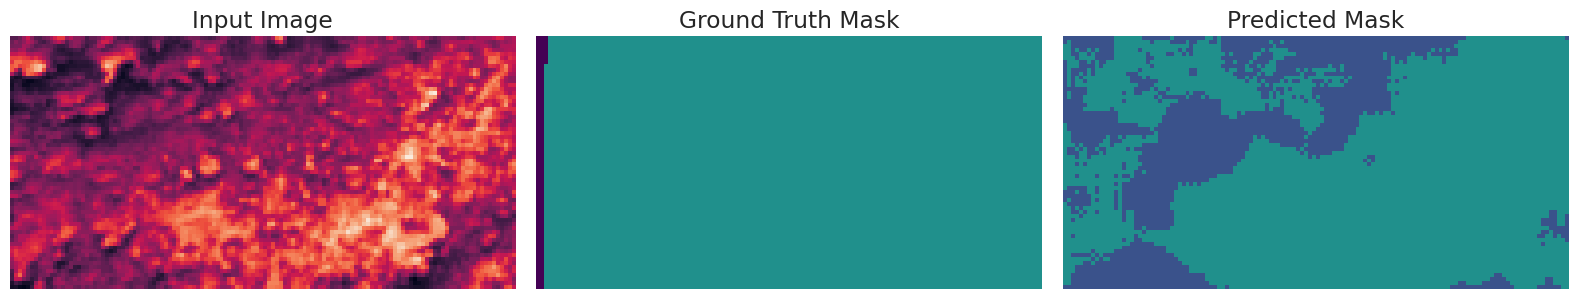

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0057 - mean_iou: 0.8193 - val_loss: 0.0562 - val_mean_iou: 0.6771 - learning_rate: 5.0000e-04
Epoch 112/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0071 - mean_iou: 0.8050 - val_loss: 0.0542 - val_mean_iou: 0.6368 - learning_rate: 5.0000e-04
Epoch 113/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0095 - mean_iou: 0.7656 - val_loss: 0.0510 - val_mean_iou: 0.6466 - learning_rate: 5.0000e-04
Epoch 114/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0058 - mean_iou: 0.8129 - val_loss: 0.0485 - val_mean_iou: 0.6551 - learning_rate: 5.0000e-04
Epoch 115/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0059 - mean_iou: 0.8233 - val_loss: 0.0545 - val_mean_iou: 0.6672 - learning_rate: 5.0000e-04
Epoch 116/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0055 - mean_iou: 0.8359

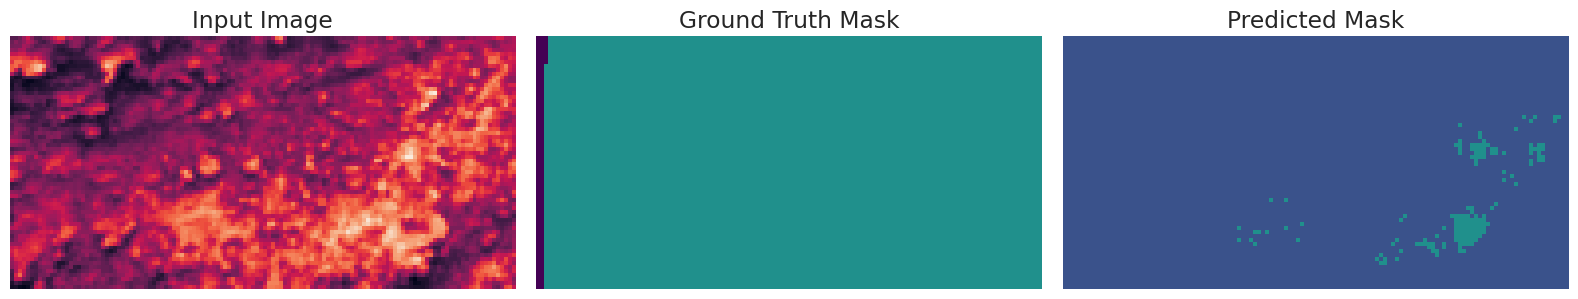

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0055 - mean_iou: 0.8360 - val_loss: 0.0520 - val_mean_iou: 0.6705 - learning_rate: 5.0000e-04
Epoch 117/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0055 - mean_iou: 0.8199 - val_loss: 0.0583 - val_mean_iou: 0.6755 - learning_rate: 5.0000e-04
Epoch 118/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0111 - mean_iou: 0.7510 - val_loss: 0.0560 - val_mean_iou: 0.5298 - learning_rate: 5.0000e-04
Epoch 119/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0137 - mean_iou: 0.6813 - val_loss: 0.0390 - val_mean_iou: 0.6748 - learning_rate: 5.0000e-04
Epoch 120/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0059 - mean_iou: 0.8235 - val_loss: 0.0429 - val_mean_iou: 0.6627 - learning_rate: 5.0000e-04
Epoch 121/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0048 - mean_iou: 0.8496

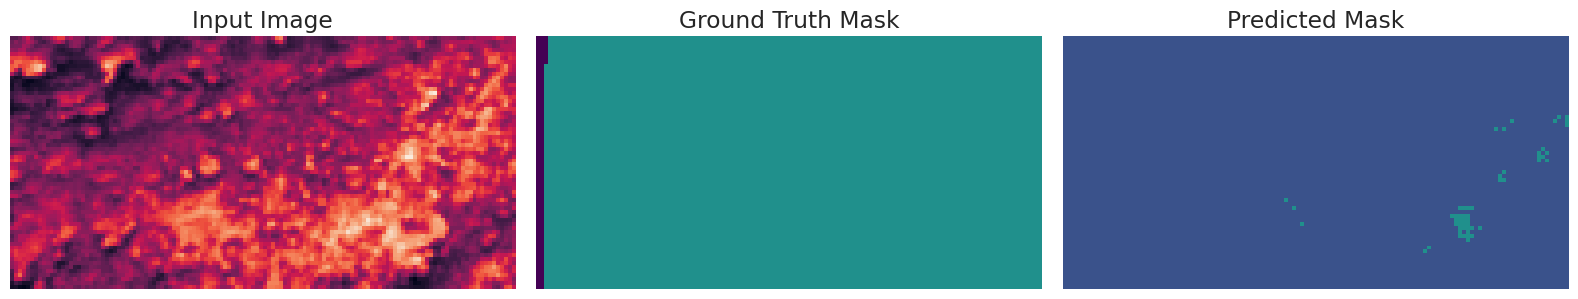


Epoch 121: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0048 - mean_iou: 0.8496 - val_loss: 0.0476 - val_mean_iou: 0.6527 - learning_rate: 5.0000e-04
Epoch 122/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0047 - mean_iou: 0.8413 - val_loss: 0.0504 - val_mean_iou: 0.6726 - learning_rate: 2.5000e-04
Epoch 123/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0046 - mean_iou: 0.8683 - val_loss: 0.0519 - val_mean_iou: 0.6771 - learning_rate: 2.5000e-04
Epoch 124/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0044 - mean_iou: 0.8713 - val_loss: 0.0540 - val_mean_iou: 0.6717 - learning_rate: 2.5000e-04
Epoch 125/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0042 - mean_iou: 0.8823 - val_loss: 0.0547 - val_mean_iou: 0.6783 - learning_rate: 2.5000e-04
Epoch 126/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0040 - mean_iou: 0.8881

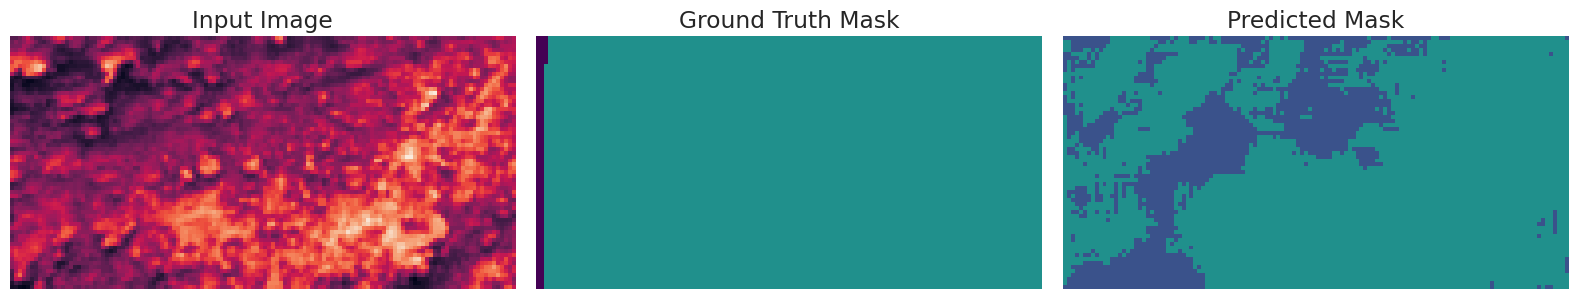

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0040 - mean_iou: 0.8882 - val_loss: 0.0564 - val_mean_iou: 0.6833 - learning_rate: 2.5000e-04
Epoch 127/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0039 - mean_iou: 0.8937 - val_loss: 0.0570 - val_mean_iou: 0.6837 - learning_rate: 2.5000e-04
Epoch 128/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0037 - mean_iou: 0.8957 - val_loss: 0.0590 - val_mean_iou: 0.6812 - learning_rate: 2.5000e-04
Epoch 129/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0036 - mean_iou: 0.8947 - val_loss: 0.0605 - val_mean_iou: 0.6845 - learning_rate: 2.5000e-04
Epoch 130/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0036 - mean_iou: 0.8948 - val_loss: 0.0639 - val_mean_iou: 0.6853 - learning_rate: 2.5000e-04
Epoch 131/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0034 - mean_iou: 0.9070

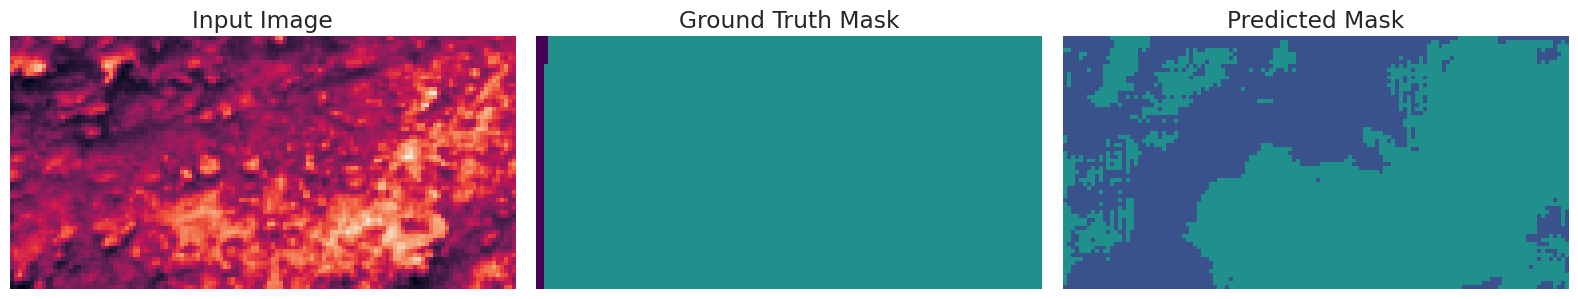

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0034 - mean_iou: 0.9070 - val_loss: 0.0645 - val_mean_iou: 0.6877 - learning_rate: 2.5000e-04
Epoch 132/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0034 - mean_iou: 0.9079 - val_loss: 0.0613 - val_mean_iou: 0.6824 - learning_rate: 2.5000e-04
Epoch 133/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0034 - mean_iou: 0.9011 - val_loss: 0.0686 - val_mean_iou: 0.6758 - learning_rate: 2.5000e-04
Epoch 134/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0035 - mean_iou: 0.9068 - val_loss: 0.0686 - val_mean_iou: 0.6882 - learning_rate: 2.5000e-04
Epoch 135/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0033 - mean_iou: 0.9130 - val_loss: 0.0538 - val_mean_iou: 0.6743 - learning_rate: 2.5000e-04
Epoch 136/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0066 - mean_iou: 0.7811

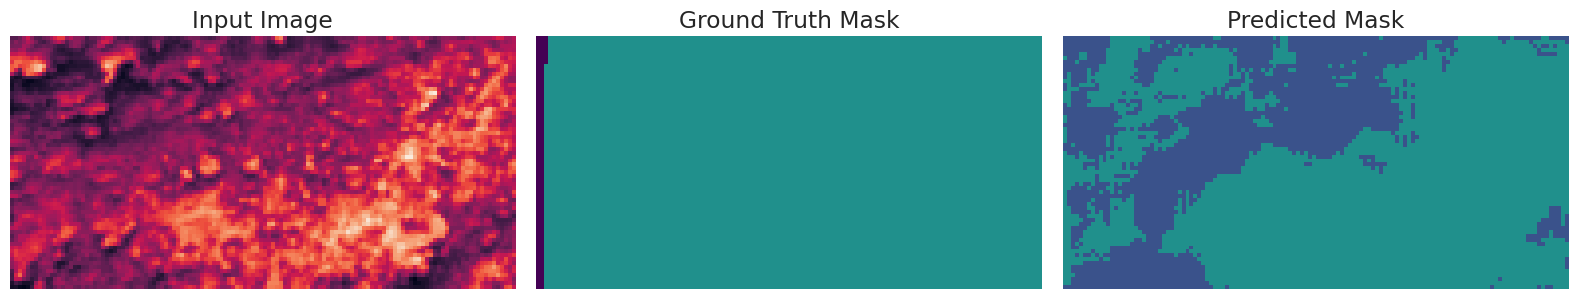

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0066 - mean_iou: 0.7814 - val_loss: 0.0598 - val_mean_iou: 0.6788 - learning_rate: 2.5000e-04
Epoch 137/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0035 - mean_iou: 0.8902 - val_loss: 0.0643 - val_mean_iou: 0.6658 - learning_rate: 2.5000e-04
Epoch 138/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0034 - mean_iou: 0.9087 - val_loss: 0.0679 - val_mean_iou: 0.6776 - learning_rate: 2.5000e-04
Epoch 139/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0031 - mean_iou: 0.9188 - val_loss: 0.0695 - val_mean_iou: 0.6858 - learning_rate: 2.5000e-04
Epoch 140/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0031 - mean_iou: 0.9114 - val_loss: 0.0640 - val_mean_iou: 0.6857 - learning_rate: 2.5000e-04
Epoch 141/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0029 - mean_iou: 0.9182

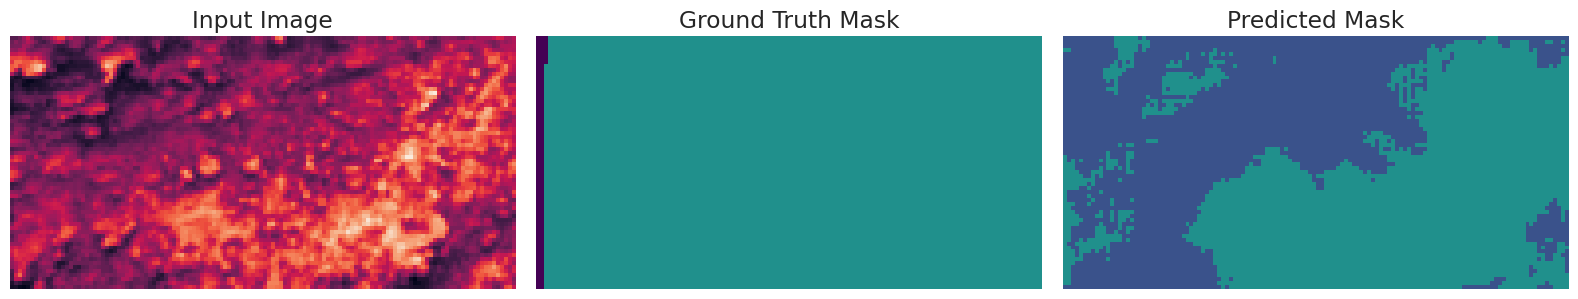

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0030 - mean_iou: 0.9181 - val_loss: 0.0688 - val_mean_iou: 0.6749 - learning_rate: 2.5000e-04
Epoch 142/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0036 - mean_iou: 0.8924 - val_loss: 0.0490 - val_mean_iou: 0.6388 - learning_rate: 2.5000e-04
Epoch 143/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0063 - mean_iou: 0.8030 - val_loss: 0.0586 - val_mean_iou: 0.6849 - learning_rate: 2.5000e-04
Epoch 144/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0038 - mean_iou: 0.8921
Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0038 - mean_iou: 0.8921 - val_loss: 0.0558 - val_mean_iou: 0.6793 - learning_rate: 2.5000e-04
Epoch 145/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0032 - mean_iou: 0.8963 - val_loss: 0.0553 - val_mean_iou: 0.6868 - learning_rate: 1.2500e-04
Epoch 146/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms

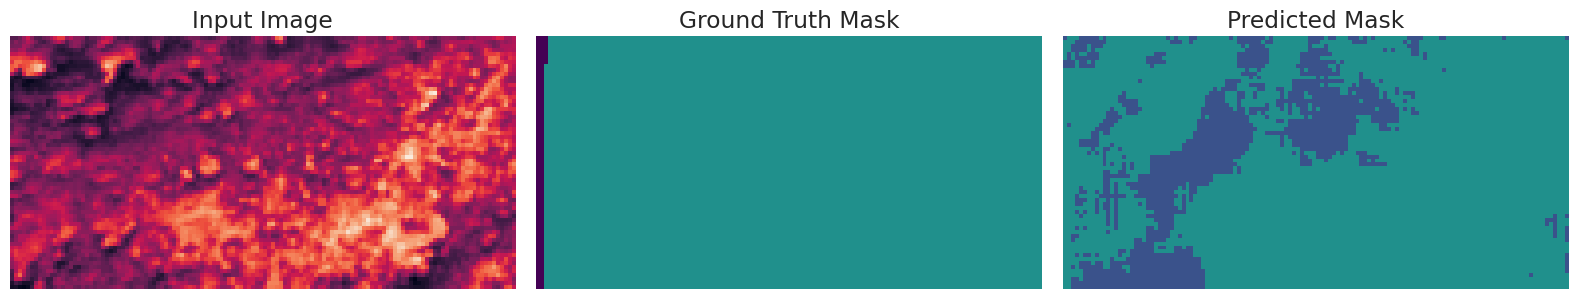

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0030 - mean_iou: 0.9018 - val_loss: 0.0572 - val_mean_iou: 0.6904 - learning_rate: 1.2500e-04
Epoch 147/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0029 - mean_iou: 0.9101 - val_loss: 0.0593 - val_mean_iou: 0.6913 - learning_rate: 1.2500e-04
Epoch 148/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0028 - mean_iou: 0.9160 - val_loss: 0.0634 - val_mean_iou: 0.6937 - learning_rate: 1.2500e-04
Epoch 149/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0027 - mean_iou: 0.9228 - val_loss: 0.0633 - val_mean_iou: 0.6897 - learning_rate: 1.2500e-04
Epoch 150/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0027 - mean_iou: 0.9181 - val_loss: 0.0654 - val_mean_iou: 0.6924 - learning_rate: 1.2500e-04
Epoch 151/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0026 - mean_iou: 0.9252

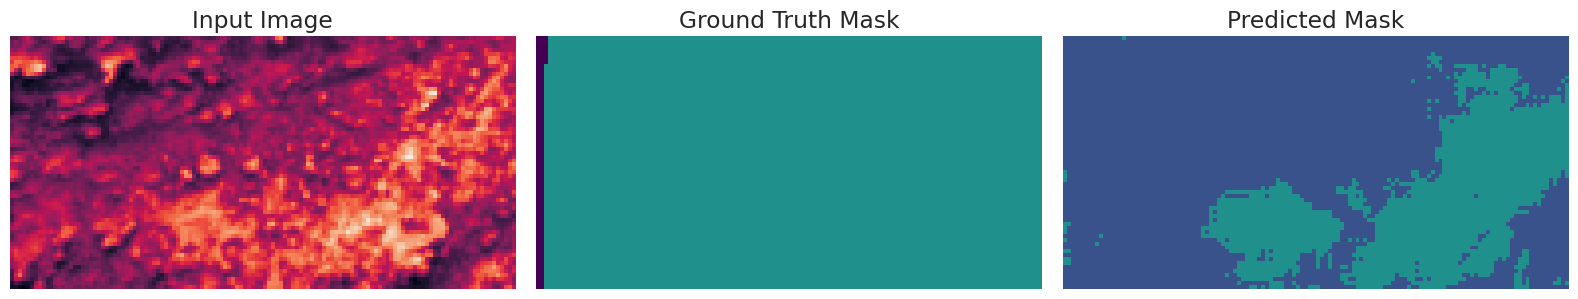

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0026 - mean_iou: 0.9253 - val_loss: 0.0685 - val_mean_iou: 0.6942 - learning_rate: 1.2500e-04
Epoch 152/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0026 - mean_iou: 0.9313 - val_loss: 0.0684 - val_mean_iou: 0.6932 - learning_rate: 1.2500e-04
Epoch 153/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0025 - mean_iou: 0.9294 - val_loss: 0.0680 - val_mean_iou: 0.6920 - learning_rate: 1.2500e-04
Epoch 154/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0025 - mean_iou: 0.9355 - val_loss: 0.0687 - val_mean_iou: 0.6906 - learning_rate: 1.2500e-04
Epoch 155/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0024 - mean_iou: 0.9359 - val_loss: 0.0721 - val_mean_iou: 0.6940 - learning_rate: 1.2500e-04
Epoch 156/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0024 - mean_iou: 0.9396

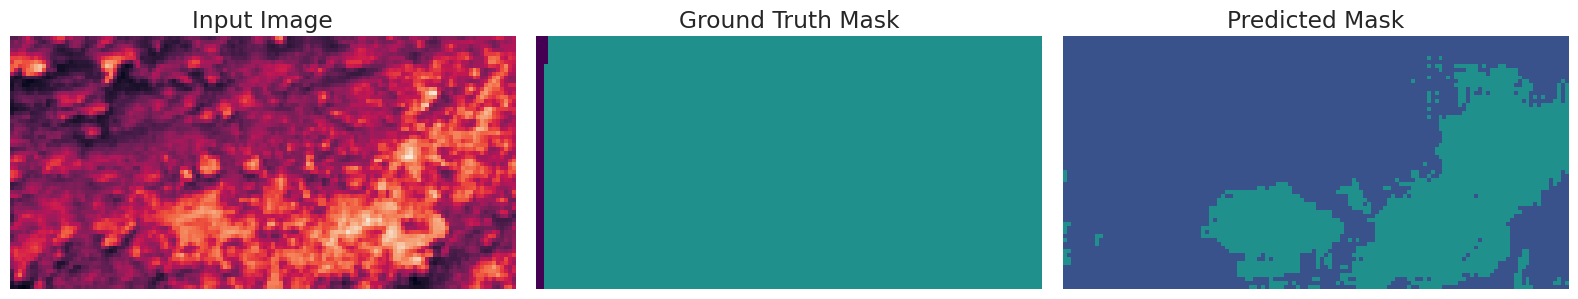

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0024 - mean_iou: 0.9397 - val_loss: 0.0738 - val_mean_iou: 0.6933 - learning_rate: 1.2500e-04
Epoch 157/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0024 - mean_iou: 0.9408 - val_loss: 0.0730 - val_mean_iou: 0.6916 - learning_rate: 1.2500e-04
Epoch 158/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0023 - mean_iou: 0.9425 - val_loss: 0.0728 - val_mean_iou: 0.6926 - learning_rate: 1.2500e-04
Epoch 159/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0023 - mean_iou: 0.9417 - val_loss: 0.0771 - val_mean_iou: 0.6894 - learning_rate: 1.2500e-04
Epoch 160/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0022 - mean_iou: 0.9407 - val_loss: 0.0781 - val_mean_iou: 0.6929 - learning_rate: 1.2500e-04
Epoch 161/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0024 - mean_iou: 0.9405

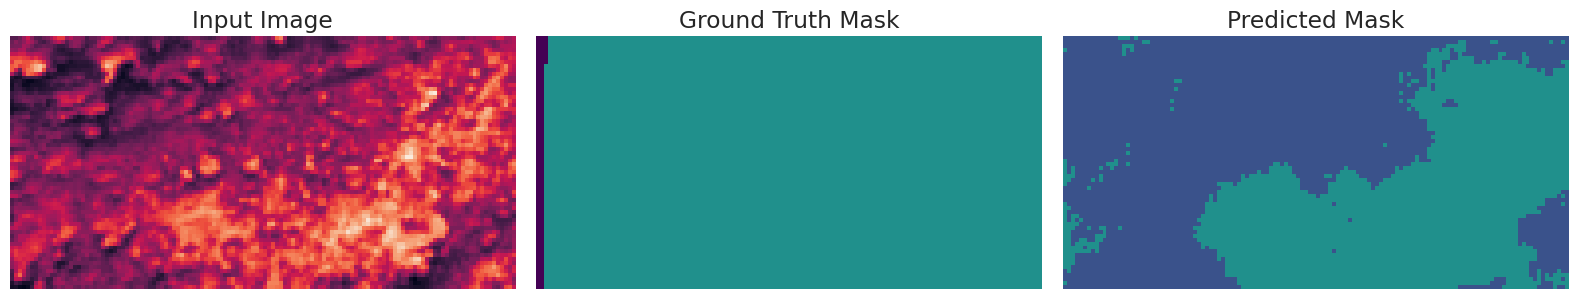


Epoch 161: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0024 - mean_iou: 0.9405 - val_loss: 0.0776 - val_mean_iou: 0.6906 - learning_rate: 1.2500e-04
Epoch 162/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0023 - mean_iou: 0.9378 - val_loss: 0.0755 - val_mean_iou: 0.6973 - learning_rate: 6.2500e-05
Epoch 163/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0022 - mean_iou: 0.9424 - val_loss: 0.0778 - val_mean_iou: 0.6969 - learning_rate: 6.2500e-05
Epoch 164/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0021 - mean_iou: 0.9447 - val_loss: 0.0807 - val_mean_iou: 0.6970 - learning_rate: 6.2500e-05
Epoch 165/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0021 - mean_iou: 0.9466 - val_loss: 0.0820 - val_mean_iou: 0.6976 - learning_rate: 6.2500e-05
Epoch 166/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0021 - mean_iou: 0.9480

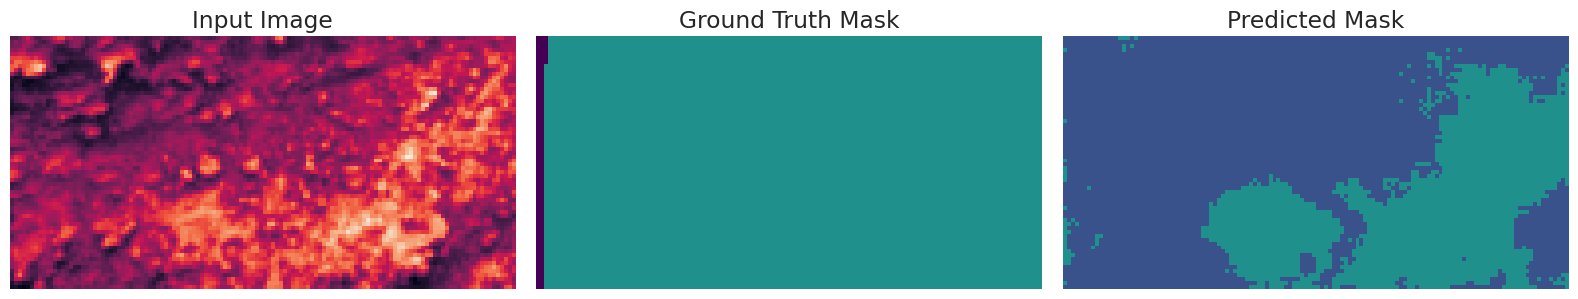

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0021 - mean_iou: 0.9480 - val_loss: 0.0836 - val_mean_iou: 0.6977 - learning_rate: 6.2500e-05
Epoch 167/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0020 - mean_iou: 0.9511 - val_loss: 0.0830 - val_mean_iou: 0.6970 - learning_rate: 6.2500e-05
Epoch 168/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0021 - mean_iou: 0.9426 - val_loss: 0.0839 - val_mean_iou: 0.6986 - learning_rate: 6.2500e-05
Epoch 169/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0020 - mean_iou: 0.9497 - val_loss: 0.0875 - val_mean_iou: 0.6993 - learning_rate: 6.2500e-05
Epoch 170/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0020 - mean_iou: 0.9541 - val_loss: 0.0857 - val_mean_iou: 0.6970 - learning_rate: 6.2500e-05
Epoch 171/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0019 - mean_iou: 0.9547

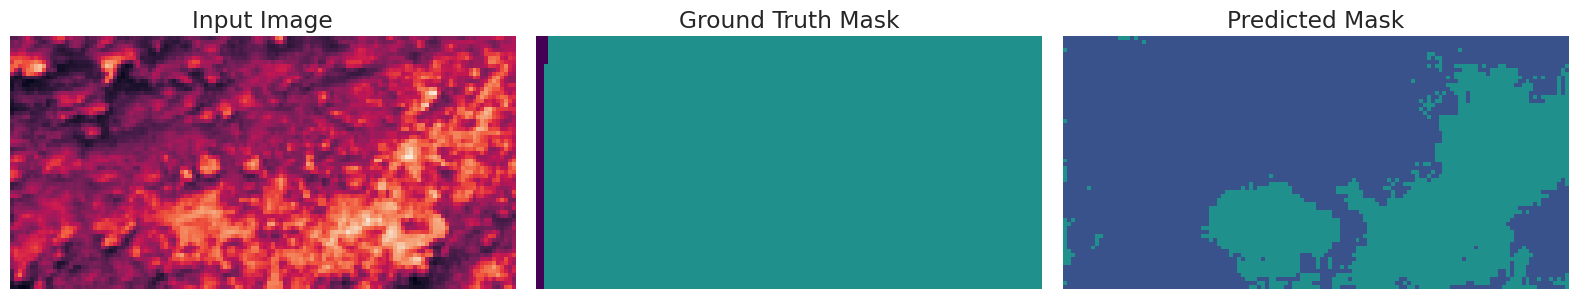

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0019 - mean_iou: 0.9547 - val_loss: 0.0872 - val_mean_iou: 0.6985 - learning_rate: 6.2500e-05
Epoch 172/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0020 - mean_iou: 0.9540 - val_loss: 0.0857 - val_mean_iou: 0.6965 - learning_rate: 6.2500e-05
Epoch 173/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0019 - mean_iou: 0.9537 - val_loss: 0.0874 - val_mean_iou: 0.6978 - learning_rate: 6.2500e-05
Epoch 174/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0019 - mean_iou: 0.9540 - val_loss: 0.0886 - val_mean_iou: 0.6974 - learning_rate: 6.2500e-05
Epoch 175/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0019 - mean_iou: 0.9564 - val_loss: 0.0885 - val_mean_iou: 0.6942 - learning_rate: 6.2500e-05
Epoch 176/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0019 - mean_iou: 0.9502

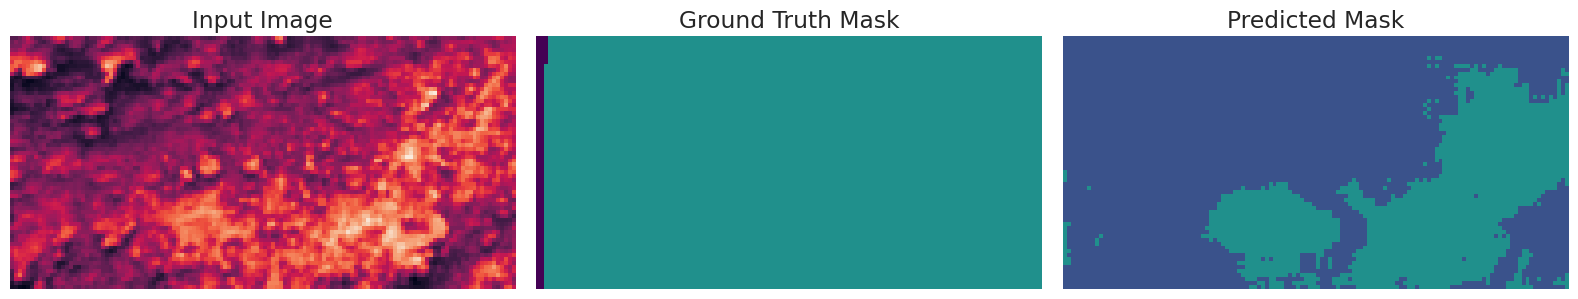

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0019 - mean_iou: 0.9503 - val_loss: 0.0894 - val_mean_iou: 0.6943 - learning_rate: 6.2500e-05
Epoch 177/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0019 - mean_iou: 0.9565 - val_loss: 0.0901 - val_mean_iou: 0.6973 - learning_rate: 6.2500e-05
Epoch 178/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0018 - mean_iou: 0.9584 - val_loss: 0.0904 - val_mean_iou: 0.6968 - learning_rate: 6.2500e-05
Epoch 179/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0018 - mean_iou: 0.9569
Epoch 179: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9569 - val_loss: 0.0913 - val_mean_iou: 0.6962 - learning_rate: 6.2500e-05
Epoch 180/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9582 - val_loss: 0.0914 - val_mean_iou: 0.6982 - learning_rate: 3.1250e-05
Epoch 181/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms

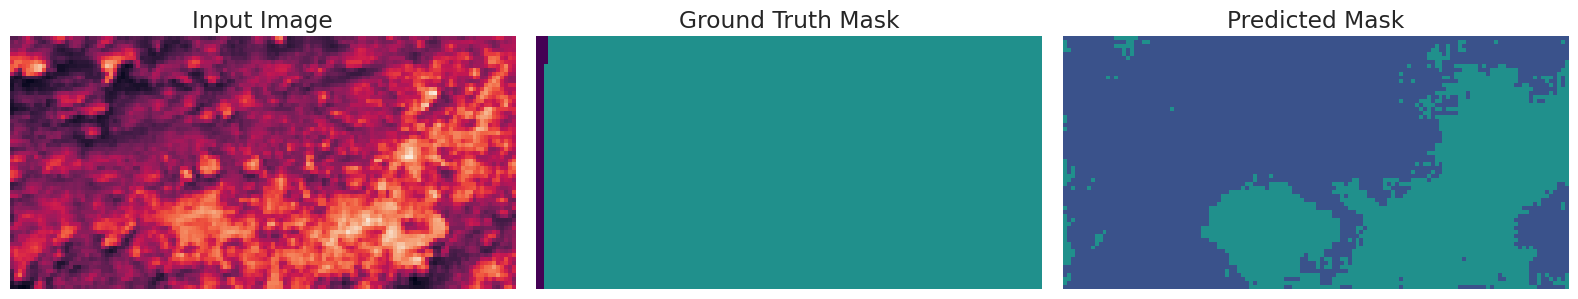

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0019 - mean_iou: 0.9504 - val_loss: 0.0976 - val_mean_iou: 0.7002 - learning_rate: 3.1250e-05
Epoch 182/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9598 - val_loss: 0.0986 - val_mean_iou: 0.6999 - learning_rate: 3.1250e-05
Epoch 183/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9599 - val_loss: 0.0982 - val_mean_iou: 0.7006 - learning_rate: 3.1250e-05
Epoch 184/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9601 - val_loss: 0.1003 - val_mean_iou: 0.7011 - learning_rate: 3.1250e-05
Epoch 185/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0018 - mean_iou: 0.9604 - val_loss: 0.0999 - val_mean_iou: 0.7000 - learning_rate: 3.1250e-05
Epoch 186/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0018 - mean_iou: 0.9615

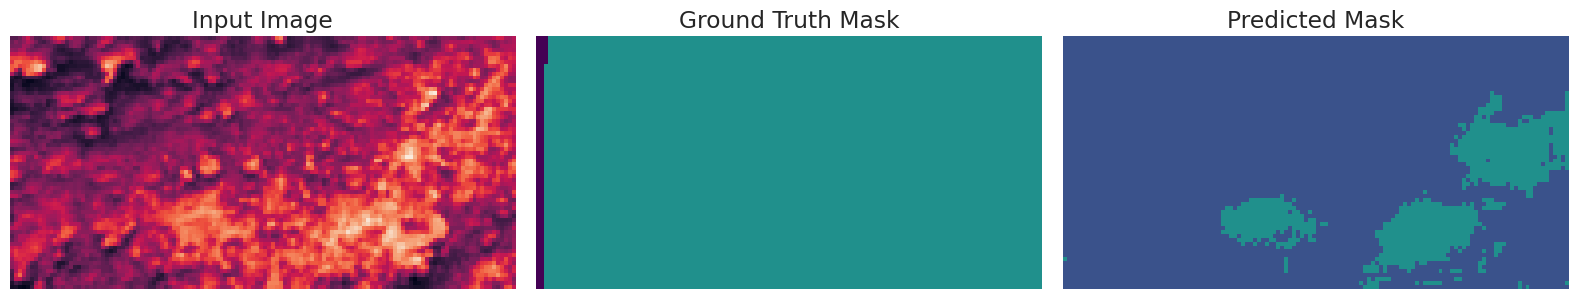

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0018 - mean_iou: 0.9615 - val_loss: 0.1009 - val_mean_iou: 0.7000 - learning_rate: 3.1250e-05
Epoch 187/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9629 - val_loss: 0.1015 - val_mean_iou: 0.7015 - learning_rate: 3.1250e-05
Epoch 188/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9634 - val_loss: 0.1014 - val_mean_iou: 0.6995 - learning_rate: 3.1250e-05
Epoch 189/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9629 - val_loss: 0.1027 - val_mean_iou: 0.7011 - learning_rate: 3.1250e-05
Epoch 190/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9647 - val_loss: 0.1019 - val_mean_iou: 0.7001 - learning_rate: 3.1250e-05
Epoch 191/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0017 - mean_iou: 0.9648

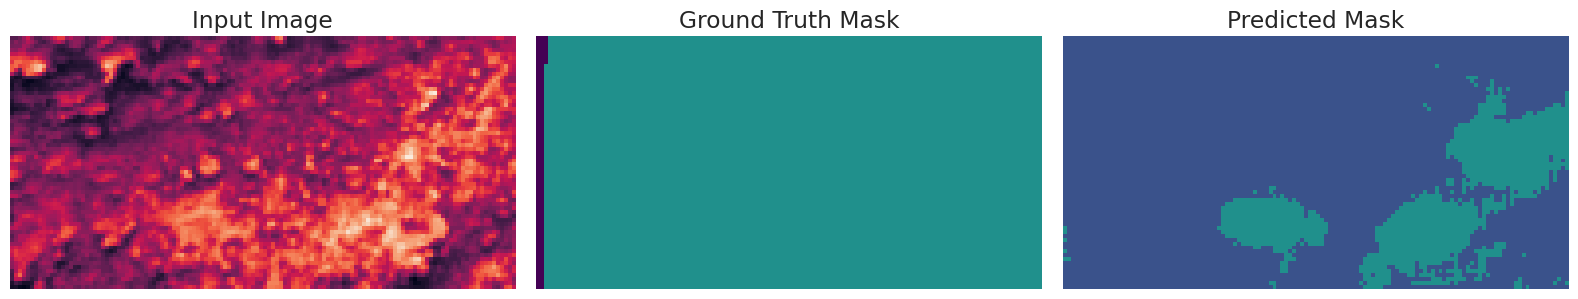

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0017 - mean_iou: 0.9647 - val_loss: 0.1039 - val_mean_iou: 0.7007 - learning_rate: 3.1250e-05
Epoch 192/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9640 - val_loss: 0.1034 - val_mean_iou: 0.6995 - learning_rate: 3.1250e-05
Epoch 193/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9642 - val_loss: 0.1048 - val_mean_iou: 0.7009 - learning_rate: 3.1250e-05
Epoch 194/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9648 - val_loss: 0.1055 - val_mean_iou: 0.6999 - learning_rate: 3.1250e-05
Epoch 195/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9643 - val_loss: 0.1048 - val_mean_iou: 0.7003 - learning_rate: 3.1250e-05
Epoch 196/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0016 - mean_iou: 0.9592

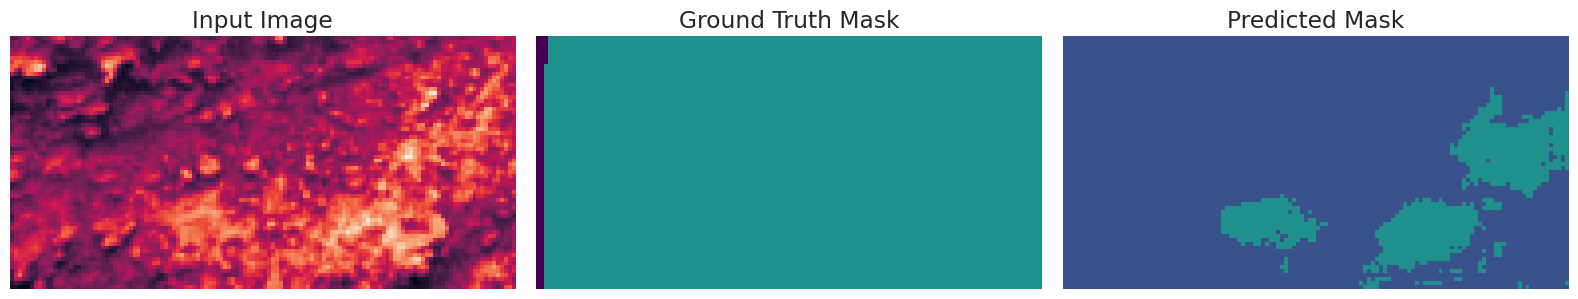

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0016 - mean_iou: 0.9593 - val_loss: 0.1050 - val_mean_iou: 0.6996 - learning_rate: 3.1250e-05
Epoch 197/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0016 - mean_iou: 0.9663
Epoch 197: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9663 - val_loss: 0.1077 - val_mean_iou: 0.7014 - learning_rate: 3.1250e-05
Epoch 198/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9630 - val_loss: 0.1091 - val_mean_iou: 0.7001 - learning_rate: 1.5625e-05
Epoch 199/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9619 - val_loss: 0.1098 - val_mean_iou: 0.6998 - learning_rate: 1.5625e-05
Epoch 200/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0017 - mean_iou: 0.9665 - val_loss: 0.1106 - val_mean_iou: 0.7007 - learning_rate: 1.5625e-05
Epoch 201/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72m

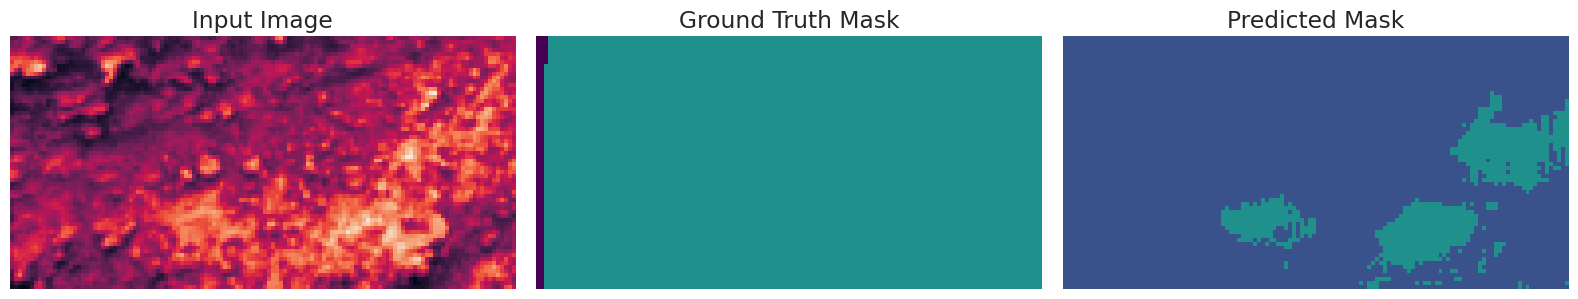

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0016 - mean_iou: 0.9669 - val_loss: 0.1110 - val_mean_iou: 0.7009 - learning_rate: 1.5625e-05
Epoch 202/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9672 - val_loss: 0.1104 - val_mean_iou: 0.7007 - learning_rate: 1.5625e-05
Epoch 203/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9659 - val_loss: 0.1110 - val_mean_iou: 0.7011 - learning_rate: 1.5625e-05
Epoch 204/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9675 - val_loss: 0.1114 - val_mean_iou: 0.7016 - learning_rate: 1.5625e-05
Epoch 205/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9677 - val_loss: 0.1104 - val_mean_iou: 0.7012 - learning_rate: 1.5625e-05
Epoch 206/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0016 - mean_iou: 0.9680

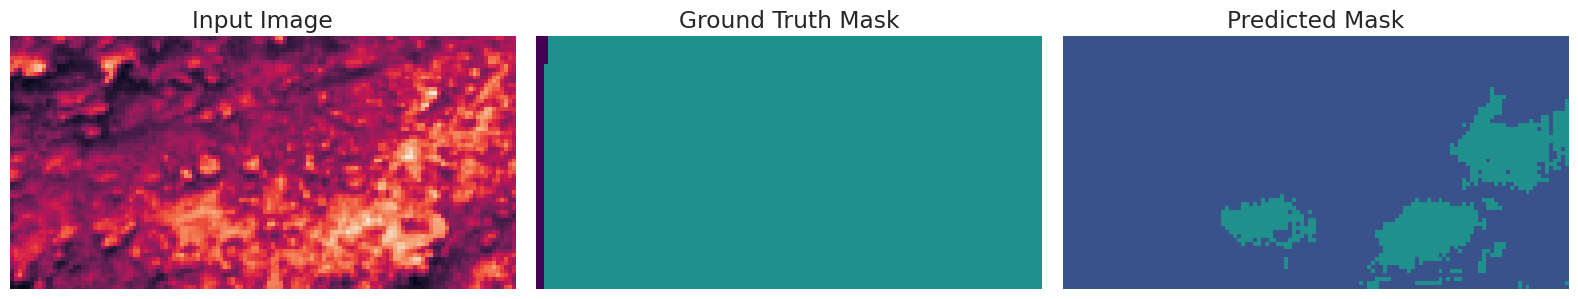

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0016 - mean_iou: 0.9680 - val_loss: 0.1115 - val_mean_iou: 0.7015 - learning_rate: 1.5625e-05
Epoch 207/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0016 - mean_iou: 0.9687
Epoch 207: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0016 - mean_iou: 0.9686 - val_loss: 0.1117 - val_mean_iou: 0.7013 - learning_rate: 1.5625e-05
Epoch 208/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0016 - mean_iou: 0.9692 - val_loss: 0.1125 - val_mean_iou: 0.7002 - learning_rate: 7.8125e-06
Epoch 209/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0016 - mean_iou: 0.9696 - val_loss: 0.1131 - val_mean_iou: 0.6998 - learning_rate: 7.8125e-06
Epoch 210/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0016 - mean_iou: 0.9697 - val_loss: 0.1130 - val_mean_iou: 0.6996 - learning_rate: 7.8125e-06
Epoch 211/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms

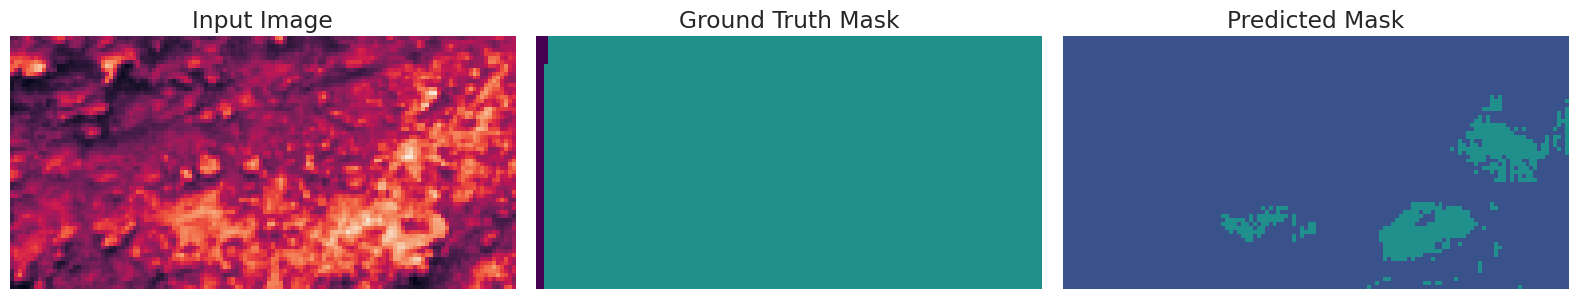

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0015 - mean_iou: 0.9699 - val_loss: 0.1132 - val_mean_iou: 0.6991 - learning_rate: 7.8125e-06
Epoch 212/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0016 - mean_iou: 0.9680 - val_loss: 0.1134 - val_mean_iou: 0.6991 - learning_rate: 7.8125e-06
Epoch 213/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9704 - val_loss: 0.1135 - val_mean_iou: 0.6989 - learning_rate: 7.8125e-06
Epoch 214/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9703 - val_loss: 0.1136 - val_mean_iou: 0.6988 - learning_rate: 7.8125e-06
Epoch 215/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9704 - val_loss: 0.1137 - val_mean_iou: 0.6989 - learning_rate: 7.8125e-06
Epoch 216/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0015 - mean_iou: 0.9707

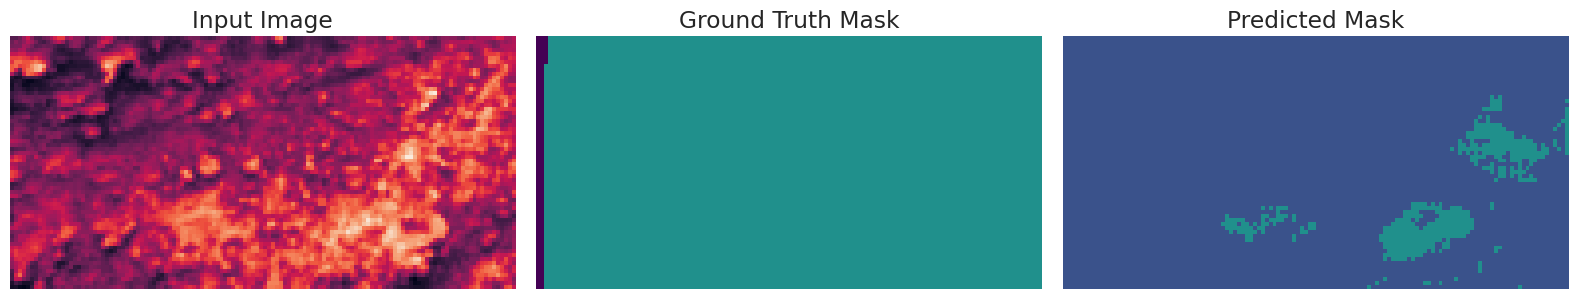

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015 - mean_iou: 0.9706 - val_loss: 0.1138 - val_mean_iou: 0.6987 - learning_rate: 7.8125e-06
Epoch 217/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0015 - mean_iou: 0.9710
Epoch 217: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9710 - val_loss: 0.1141 - val_mean_iou: 0.6984 - learning_rate: 7.8125e-06
Epoch 218/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9708 - val_loss: 0.1128 - val_mean_iou: 0.6985 - learning_rate: 3.9063e-06
Epoch 219/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9715 - val_loss: 0.1131 - val_mean_iou: 0.6985 - learning_rate: 3.9063e-06
Epoch 220/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9689 - val_loss: 0.1131 - val_mean_iou: 0.6984 - learning_rate: 3.9063e-06
Epoch 221/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms

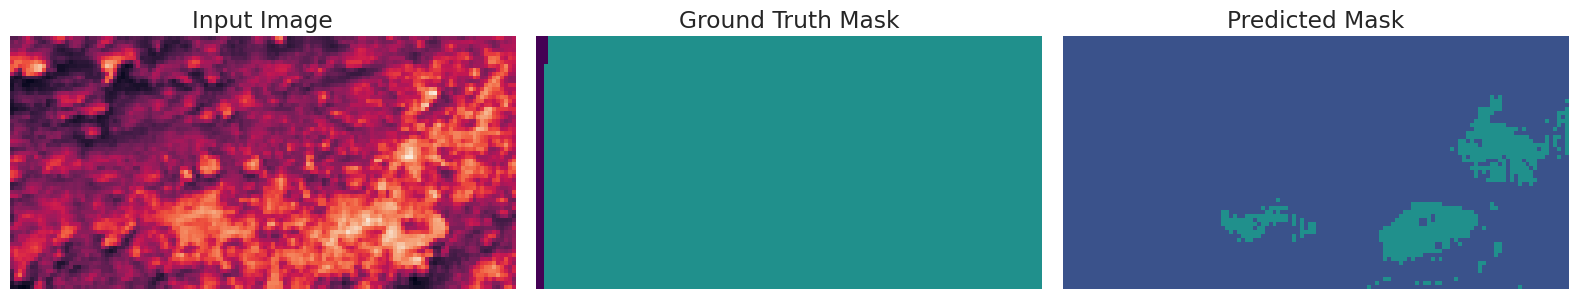

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015 - mean_iou: 0.9713 - val_loss: 0.1132 - val_mean_iou: 0.6985 - learning_rate: 3.9063e-06
Epoch 222/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9715 - val_loss: 0.1133 - val_mean_iou: 0.6985 - learning_rate: 3.9063e-06
Epoch 223/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9714 - val_loss: 0.1134 - val_mean_iou: 0.6985 - learning_rate: 3.9063e-06
Epoch 224/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9711 - val_loss: 0.1134 - val_mean_iou: 0.6986 - learning_rate: 3.9063e-06
Epoch 225/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9717 - val_loss: 0.1136 - val_mean_iou: 0.6986 - learning_rate: 3.9063e-06
Epoch 226/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0015 - mean_iou: 0.9719

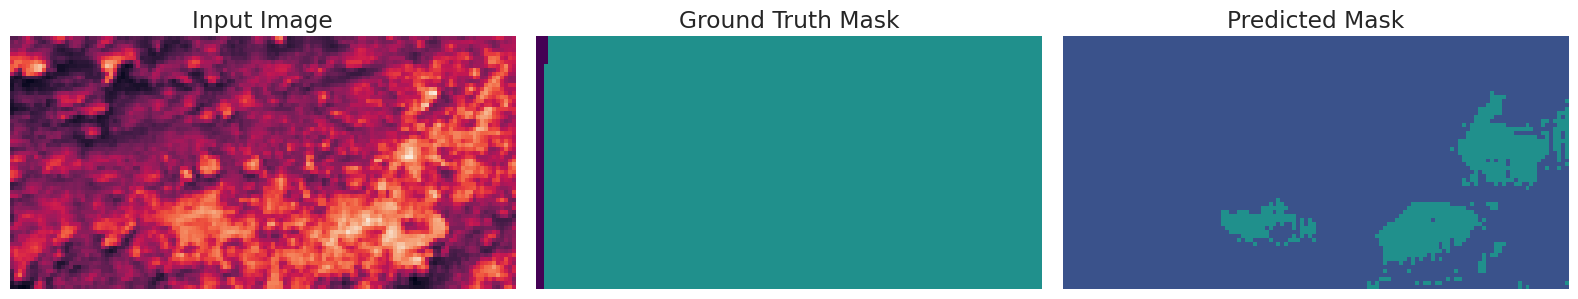

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015 - mean_iou: 0.9718 - val_loss: 0.1136 - val_mean_iou: 0.6987 - learning_rate: 3.9063e-06
Epoch 227/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0015 - mean_iou: 0.9720
Epoch 227: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9719 - val_loss: 0.1136 - val_mean_iou: 0.6988 - learning_rate: 3.9063e-06
Epoch 228/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9700 - val_loss: 0.1127 - val_mean_iou: 0.6996 - learning_rate: 1.9531e-06
Epoch 229/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9723 - val_loss: 0.1128 - val_mean_iou: 0.6995 - learning_rate: 1.9531e-06
Epoch 230/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9716 - val_loss: 0.1128 - val_mean_iou: 0.6994 - learning_rate: 1.9531e-06
Epoch 231/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 71m

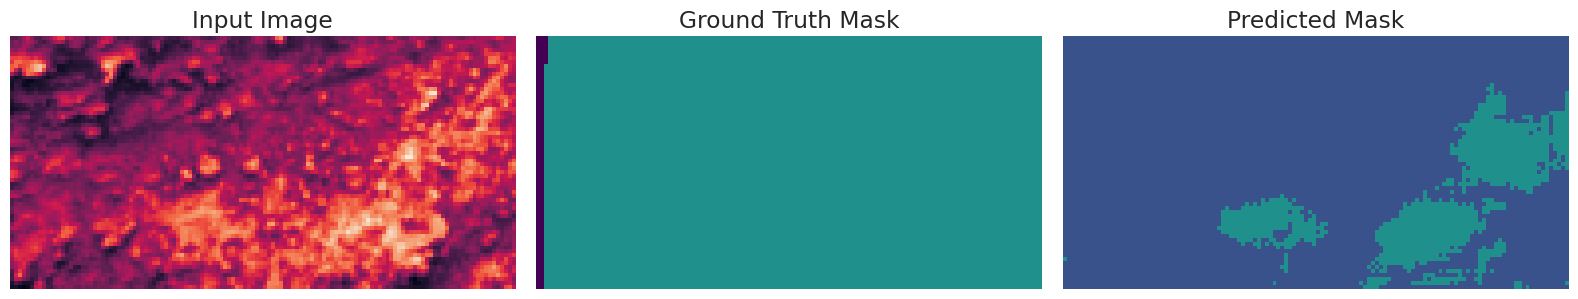

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015 - mean_iou: 0.9716 - val_loss: 0.1128 - val_mean_iou: 0.6996 - learning_rate: 1.9531e-06
Epoch 232/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0015 - mean_iou: 0.9722 - val_loss: 0.1130 - val_mean_iou: 0.6995 - learning_rate: 1.9531e-06
Epoch 233/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9722 - val_loss: 0.1130 - val_mean_iou: 0.6995 - learning_rate: 1.9531e-06
Epoch 234/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0015 - mean_iou: 0.9719 - val_loss: 0.1131 - val_mean_iou: 0.6995 - learning_rate: 1.9531e-06
Final validation Mean Intersection Over Union: 70.16%


In [23]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

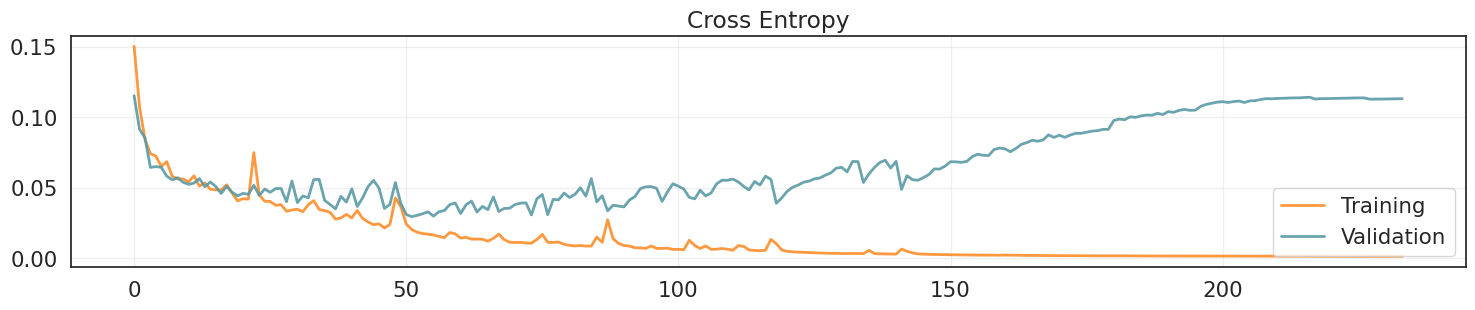

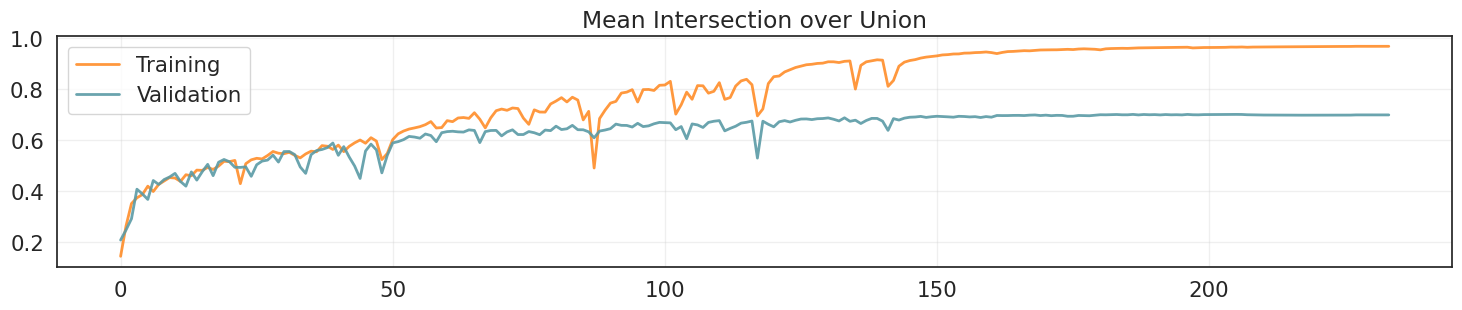

In [24]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [25]:
#Get prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step
Predictions shape: (10022, 64, 128)


In [26]:
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [27]:
submission_filename = f"CustomUNet+SqueezeFocalCw.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)